In [21]:
import numpy as np
from numpy.core import MachAr
import pandas as pd
from pandas import Series, DataFrame
import pandas as pd
from sqlalchemy import create_engine, inspect
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt, freqz, hilbert
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import math
from sklearn.metrics import mean_absolute_error
import statistics
import random
from collections import defaultdict
import shutil
from matplotlib.animation import FuncAnimation
plt.style.use('ggplot')

In [2]:
# file_path = "train.csv"

# # Define parameters for reading the CSV file (adjust as needed)
# chunk_size = 10000  # Number of rows to read at a time
# usecols = None  # Specify columns to read, or None to read all columns
# dtype = None  # Specify column data types, or None to infer types
# iterator = True  # Enable iterative reading
# chunk_index = 0  # Starting index of the chunk

# # Create an empty list to store chunk DataFrames
# chunks = []

# # Iterate over chunks of the CSV file
# for chunk in pd.read_csv(file_path, chunksize=chunk_size, usecols=usecols, dtype=dtype, iterator=iterator, skiprows=lambda x: x % 1000 != 0):
#     # Process the chunk (optional)
#     # For example, you can perform data manipulation, filtering, etc.
    
#     # Append the chunk DataFrame to the list
#     chunks.append(chunk)
    
#     # Increment chunk index
#     chunk_index += 1

# # Concatenate all chunks into a single DataFrame
# df = pd.concat(chunks, ignore_index=True)

# df.to_csv('subsampled_data.csv', index=False)

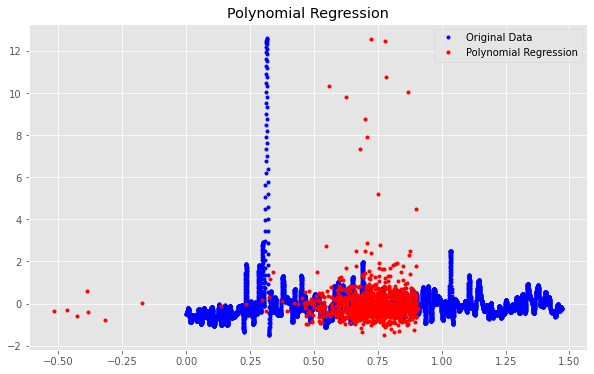

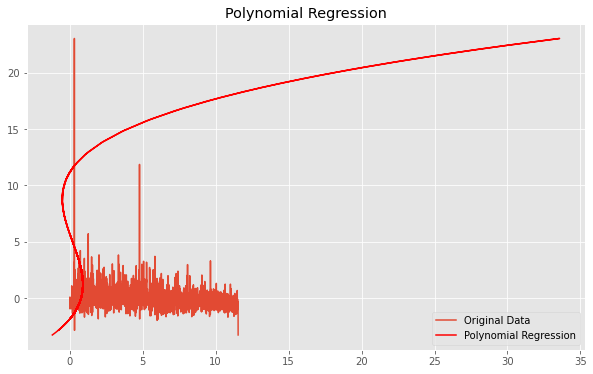

In [3]:
# plt.plot(df['time_to_failure'], df['acoustic_data'], 'r.')
# plt.xlim(2.505,2.515);plt.ylim(0,100)
df = pd.read_csv('subsampled_data.csv')


def isolate_spikes(data):
    spikes = []
    current_spike = []

    for i in range(1, len(data)):
        if data[i] > data[i - 1]:  # Check for increase
            current_spike.append((i, data[i]))
        elif current_spike:  # Check for decrease, if within a spike
            current_spike.append((i - 1, data[i - 1]))  # Append the last point of the spike
            spikes.append(current_spike)
            current_spike = []

    if current_spike:  # If the last spike extends to the end
        current_spike.append((len(data) - 1, data[-1]))
        spikes.append(current_spike)

    return spikes

def butter_lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False, fs = None)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define filter parameters
   
def spike_and_sep(datafield1, datafield2, iteration, value, order):
    
    datafield2 = datafield2[abs(datafield2)<= 200]
    sampling_rate = len(datafield1) / (datafield1.max() - datafield1.min())
    
    cutoff_frequency = sampling_rate/value
    
    spikes = isolate_spikes(datafield1)
    if iteration == 0:
        start = 0
        end = spikes[iteration][0][0]
    else: 
        start = spikes[iteration-1][0][0]
        end = spikes[iteration][0][0]
    data1 = datafield1[start:end]
    data2 = datafield2[start:end]
    
    rectified_signal = np.abs(data2)
    filtered_signal = butter_lowpass_filter(rectified_signal, cutoff_frequency, sampling_rate, order).reshape(-1,1)
    scaler =  StandardScaler()
    X_normalized = scaler.fit_transform(filtered_signal)
    
    return data1, data2, X_normalized.reshape(-1)
    
    
    
        
ttf0, ad0, adf0 = spike_and_sep(df['time_to_failure'], df['acoustic_data'],0, 50, 6)

X_train, X_test, Y_train, Y_test = train_test_split(adf0, ttf0, test_size=0.2, random_state=42)

degree = 3  # Choose the degree of the polynomial
coefficients = np.polyfit(X_train[::-1], Y_train[::-1], degree)
poly_function = np.poly1d(coefficients)

# Predict time stamps using the polynomial function
predicted_time_stamps = poly_function(X_test[::-1])

# Plot the original data and the polynomial regression curve
plt.figure(figsize=(10, 6))
plt.plot(ttf0, adf0, 'b.',label='Original Data')
plt.plot(predicted_time_stamps, X_test,'r.', label='Polynomial Regression')
plt.title('Polynomial Regression')
plt.legend()
plt.grid(True)
plt.show()


ttf1, ad1, adf1 = spike_and_sep(df['time_to_failure'], df['acoustic_data'],1, 50, 6)
predicted_stamps_1 = poly_function(adf1[::-1])

plt.figure(figsize=(10, 6))
plt.plot(ttf1[::-1],adf1[::-1], label='Original Data')
plt.plot(predicted_stamps_1, adf1[::-1],color='red', label='Polynomial Regression')
plt.title('Polynomial Regression')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\jdt45\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


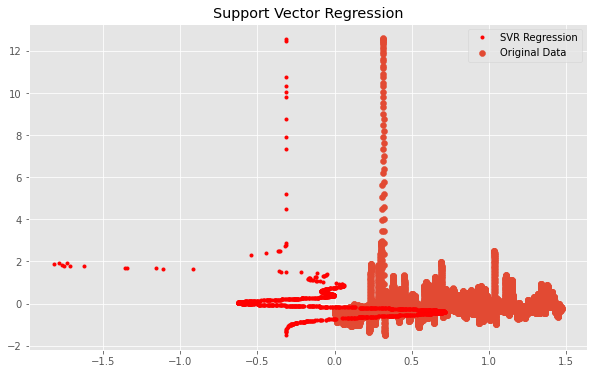

In [4]:
svr = SVR(kernel='rbf')  # You can choose different kernels (linear, polynomial, RBF, etc.)
svr.fit(Y_train.values.reshape(-1, 1)[::-1], X_train[::-1].reshape(-1, 1))

# Predict time stamps using SVR model
predicted_time_stamps = svr.predict(X_test.reshape(-1, 1) [::-1])

plt.figure(figsize=(10, 6))
plt.scatter(ttf0[::-1], adf0[::-1], label='Original Data')
plt.plot(predicted_time_stamps, X_test[::-1], 'r.', label='SVR Regression')
plt.title('Support Vector Regression')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Assuming 'X' contains your features (acoustic data) and 'Y' contains your targets (time to failure)
ttf, ad, adf =  spike_and_sep(df['time_to_failure'], df['acoustic_data'],0, 50, 6)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(ttf, adf[::-1], test_size=0.5, random_state=42)

X_train = X_train.values.reshape(1,-1); X_test = X_test.values.reshape(1, -1)
Y_train = Y_train.reshape(1,-1); Y_test = Y_test.reshape(1, -1) 

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(Y_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(Y_train, X_train, epochs=100, batch_size=32, verbose = 0)

# Evaluate the model
# loss = model.evaluate(Y_test, X_test)

X_pred = model.predict(Y_test)

print(X_pred)

1/1 [==============================] - 0s 65ms/step
[[-3.775847]]


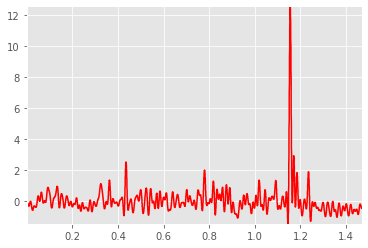

In [6]:
plt.vlines(abs(X_pred), ymin = -2000, ymax = 2000, color = 'blue')
plt.plot(ttf, adf[::-1], 'r-')
plt.ylim(min(adf), max(adf)); plt.xlim(min(ttf), max(ttf))
plt.show()

1/1 [==============================] - 0s 59ms/step
[[0.2847162]]
1/1 [==============================] - 0s 39ms/step
[[6.9083176]]
1/1 [==============================] - 0s 15ms/step


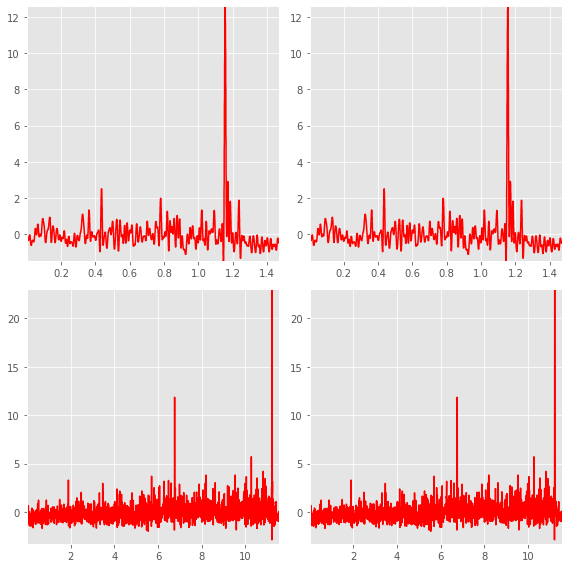

[0.2847161889076233, 6.908317565917969]


In [7]:
def NN_test(data1, data2, num_splits):
    X_pred_arr = []
    
    # Calculate the number of plots
    num_plots = (num_splits)

    # Calculate the number of rows and columns for subplots
    num_rows_cols = math.ceil(math.sqrt(num_plots))
    num_subplots = num_rows_cols ** 2  # Total number of subplots to make it square

    # Create subplots
    fig, axes = plt.subplots(num_rows_cols, num_rows_cols, figsize=(num_rows_cols * 4, num_rows_cols * 4))

    for i, ax_row in enumerate(axes):
        
        ttf, ad, adf =  spike_and_sep(data1, data2 ,i, 50, 6)
        if len(ttf) % 2 != 0:
            ttf = ttf[:-1]; ad = ad[:-1]; adf = adf[:-1]
        else:
            pass
        
        X_train, X_test, Y_train, Y_test = train_test_split(ttf, abs(adf[::-1]), test_size=0.5, random_state=42)

        X_train = X_train.values.reshape(1,-1); X_test = X_test.values.reshape(1, -1)
        Y_train = Y_train.reshape(1,-1); Y_test = Y_test.reshape(1, -1) 
        
        # Define the neural network architecture
        model = Sequential([
            Dense(64, activation='relu', input_shape=(Y_train.shape[1],)),
            Dense(32, activation='relu'),
            Dense(1)  # Output layer with one neuron for regression
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        history = model.fit(Y_train, X_train, epochs=100, batch_size=32, verbose = 0)
        
        X_pred = model.predict(Y_test)
        print(X_pred)

        X_pred_arr.append(float(model.predict(Y_test)))
    
        for j, ax in enumerate(ax_row):
            ax.plot(ttf, adf[::-1], 'r-', label='Original Data')
            ax.plot(Y_test, X_pred, 'b-', label='Predictions')
            ax.set_ylim(min(adf), max(adf))
            ax.set_xlim(min(ttf), max(ttf))
            ax.grid(True)  # Show grid
            
    for ax_row in axes:
        for ax in ax_row[num_splits:]:
            ax.remove()
    plt.tight_layout()

    # Show the plots
    plt.show()
    return X_pred_arr

print(NN_test(df['time_to_failure'], df['acoustic_data'], 3))

In [8]:
def NN_test(data1, data2, num_splits):
    X_pred_arr = []
    Y_max_arr = []
    # Calculate the number of plots
    num_plots = num_splits

    # Calculate the number of rows and columns for subplots
    num_rows_cols = math.ceil(math.sqrt(num_plots))
    num_subplots = num_rows_cols ** 2  # Total number of subplots to make it square

    # Create subplots
    fig, axes = plt.subplots(num_rows_cols, num_rows_cols, figsize=(num_rows_cols * 4, num_rows_cols * 4))

    for i in range(num_rows_cols):
        for j in range(num_rows_cols):
            ax = axes[i, j]
            index = i * num_rows_cols + j
            
            ttf, ad, adf = spike_and_sep(data1, data2, index, 50, 6)
            if len(ttf) % 2 != 0:
                ttf = ttf[:-1]; ad = ad[:-1]; adf = adf[:-1]
            else:
                pass
        
            X_train, X_test, Y_train, Y_test = train_test_split(ttf, abs(adf[::-1]), test_size=0.5, random_state=42)

            X_train = X_train.values.reshape(1,-1); X_test = X_test.values.reshape(1, -1)
            Y_train = Y_train.reshape(1,-1); Y_test = Y_test.reshape(1, -1) 
            
            # Define the neural network architecture
            model = Sequential([
            Dense(64, activation='relu', input_shape=(Y_train.shape[1],)),
            Dense(32, activation='relu'),
            Dense(1)  # Output layer with one neuron for regression
        ])

            # Compile the model
            model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model
            history = model.fit(Y_train, X_train, epochs=100, batch_size=32, verbose=0)
            X_pred = model.predict(Y_test)
            X_pred_arr.append(float(X_pred))
            
            Y_max_arr.append(float(max(ttf)))
            
            ax.plot(ttf, adf[::-1], 'r-', label='Original Data', alpha = .6)
            ax.plot(ttf, abs(adf[::-1]), 'g-', label='Absolute Data', alpha = .6)
            ax.vlines(X_pred, color = 'blue',ymin = -2000,ymax = 2000, label='Predictions')
            ax.set_ylim(-5, 15)
            ax.set_xlim(min(ttf), max(ttf))
            ax.set_xlabel('Time to Failure')
            ax.set_ylabel('Acoustic Data')
            ax.set_title('Time sample ' + str(index+1))
            ax.legend()
            ax.grid(True)  # Show grid
            
    for i in range(num_splits, num_subplots):
        axes.flatten()[i].remove()

    # Show the plots
    fig.suptitle('Initial modeling NN')
    plt.tight_layout()
    plt.savefig('Initial_modeling')
    plt.show()
    return X_pred_arr, Y_max_arr

# pred_arr, true_arr = (NN_test(df['time_to_failure'], df['acoustic_data'], 16))

In [9]:
# print(pred_arr, true_arr)

# absolute_errors = [abs(pred - true)/true for pred, true in zip(pred_arr, true_arr)]

# print(absolute_errors)

# min_index = np.argmin(absolute_errors)
# print(min_index)

In [10]:
def find_small_arr(data1, data2, num_samples):
    size_arr = []
    for i in range(num_samples):
        ttf, ad, adf = spike_and_sep(data1, data2, i, 50, 6)
        size_arr.append(len(ttf))
    return np.argmin(size_arr)    

def NN_iterate(data1, data2, num_splits, ideal_model_index, graph_name, iteration):
    X_pred_arr = []
    Y_max_arr = []
    # Calculate the number of plots
    num_plots = num_splits
    
    small_index = find_small_arr(data1,data2,num_splits)
    
    ttf_s, ad_s, adf_s = spike_and_sep(data1, data2, small_index, 50, 6)
    
    ttf_p, ad_p, adf_p = spike_and_sep(data1, data2, ideal_model_index, 50, 6)
    
    if len(ttf_s) == len(ttf_p):
        pass
    else:
        subsampling_ratio = int(len(ttf_p) / len(ttf_s))
        ttf_p = ttf_p[::subsampling_ratio][:len(ttf_s)]
        ad_p = ad_p[::subsampling_ratio][:len(ttf_s)]
        adf_p = adf_p[::subsampling_ratio][:len(ttf_s)]
        
    if len(ttf_p) % 2 != 0:
        ttf_p = ttf_p[:-1]; ad_p = ad[:-1]; adf_p = adf_p[:-1]
    else:
        pass

    X_train, X_test, Y_train, Y_test = train_test_split(ttf_p, abs(adf_p[::-1]), test_size=0.5, random_state=42)

    X_train = X_train.values.reshape(1,-1); X_test = X_test.values.reshape(1, -1)
    Y_train = Y_train.reshape(1,-1); Y_test = Y_test.reshape(1, -1) 

    model = Sequential([
            Dense(64, activation='relu', input_shape=(Y_train.shape[1],)),
            Dense(32, activation='relu'),
            Dense(1)  # Output layer with one neuron for regression
        ])

            # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model
    history = model.fit(Y_train, X_train, epochs=100, batch_size=32, verbose=0)

    # Calculate the number of rows and columns for subplots
    num_rows_cols = math.ceil(math.sqrt(num_plots))
    num_subplots = num_rows_cols ** 2  # Total number of subplots to make it square

    # Create subplots
    fig, axes = plt.subplots(num_rows_cols, num_rows_cols, figsize=(num_rows_cols * 4, num_rows_cols * 4))

    for i in range(num_rows_cols):
        for j in range(num_rows_cols):
            ax = axes[i, j]
            index = i * num_rows_cols + j
            
            ttf, ad, adf = spike_and_sep(data1, data2, index, 50, 6)
            if len(ttf_s) == len(ttf):
                pass
            else:
                subsampling_ratio = int(len(ttf) / len(ttf_s))

                ttf = ttf[::subsampling_ratio][:len(ttf_s)]
                ad = ad[::subsampling_ratio][:len(ttf_s)]
                adf = adf[::subsampling_ratio][:len(ttf_s)]
            if len(ttf) % 2 != 0:
                ttf = ttf[:-1]; ad = ad[:-1]; adf = adf[:-1]
            else:
                pass
        
            X_train, X_test, Y_train, Y_test = train_test_split(ttf, abs(adf[::-1]), test_size=0.5, random_state=42)

            X_train = X_train.values.reshape(1,-1); X_test = X_test.values.reshape(1, -1)
            Y_train = Y_train.reshape(1,-1); Y_test = Y_test.reshape(1, -1) 
            
            X_pred = model.predict(Y_test)
            X_pred_arr.append(float(X_pred))
            
            Y_max_arr.append(float(max(ttf)))
            
            ax.plot(ttf, adf[::-1], 'r-', label='Original Data', alpha = .6)
            ax.plot(ttf, abs(adf[::-1]), 'g-', label='Absolute Data', alpha = .6)
            ax.vlines(X_pred, color = 'blue',ymin = -2000,ymax = 2000, label='Predictions')
            ax.set_ylim(-5, 15)
            ax.set_xlim(min(ttf), max(ttf))
            ax.set_xlabel('Time to Failure')
            ax.set_ylabel('Acoustic Data')
            ax.set_title('Time Sample ' + str((index)+1))
            ax.legend()
            ax.grid(True)  # Show grid
            
    for i in range(num_splits, num_subplots):
        axes.flatten()[i].remove()

    # Show the plots
    fig.suptitle('Iteration ' + str(iteration) + ' Using Model ' + str(ideal_model_index))
    plt.tight_layout()
    plt.savefig(graph_name)
    plt.show()
    return X_pred_arr, Y_max_arr

# pred_arr, true_arr = (NN_iterate(df['time_to_failure'], df['acoustic_data'], 16, 6))

1/1 [==============================] - 0s 38ms/step


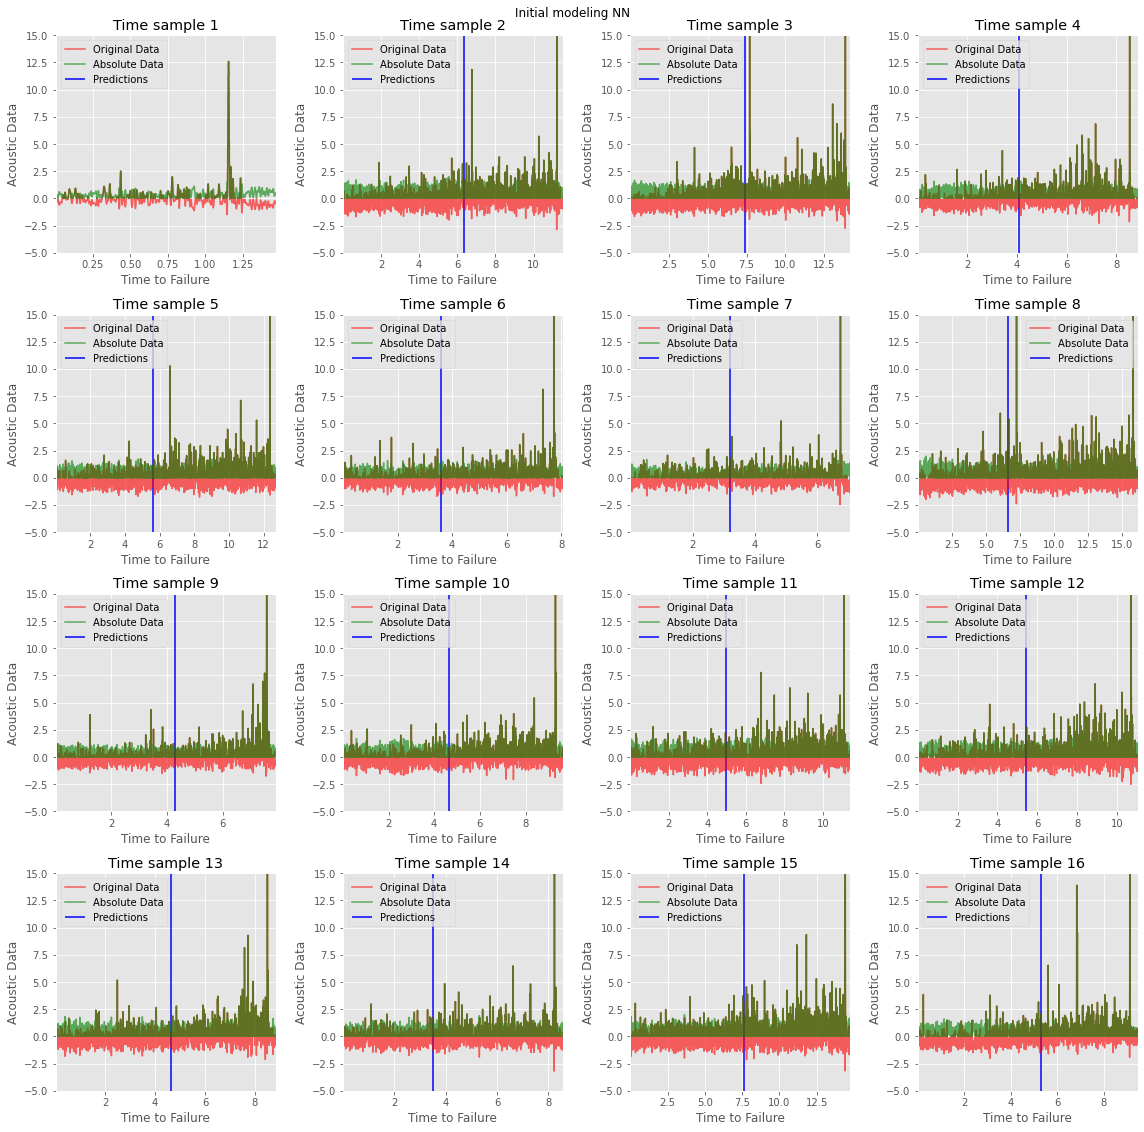

0.44094365061849705
15


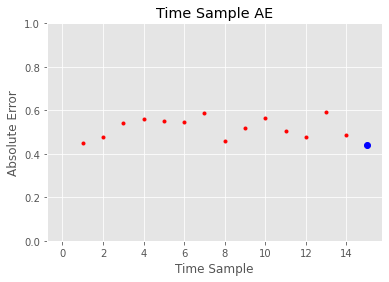

1/1 [==============================] - 0s 14ms/step


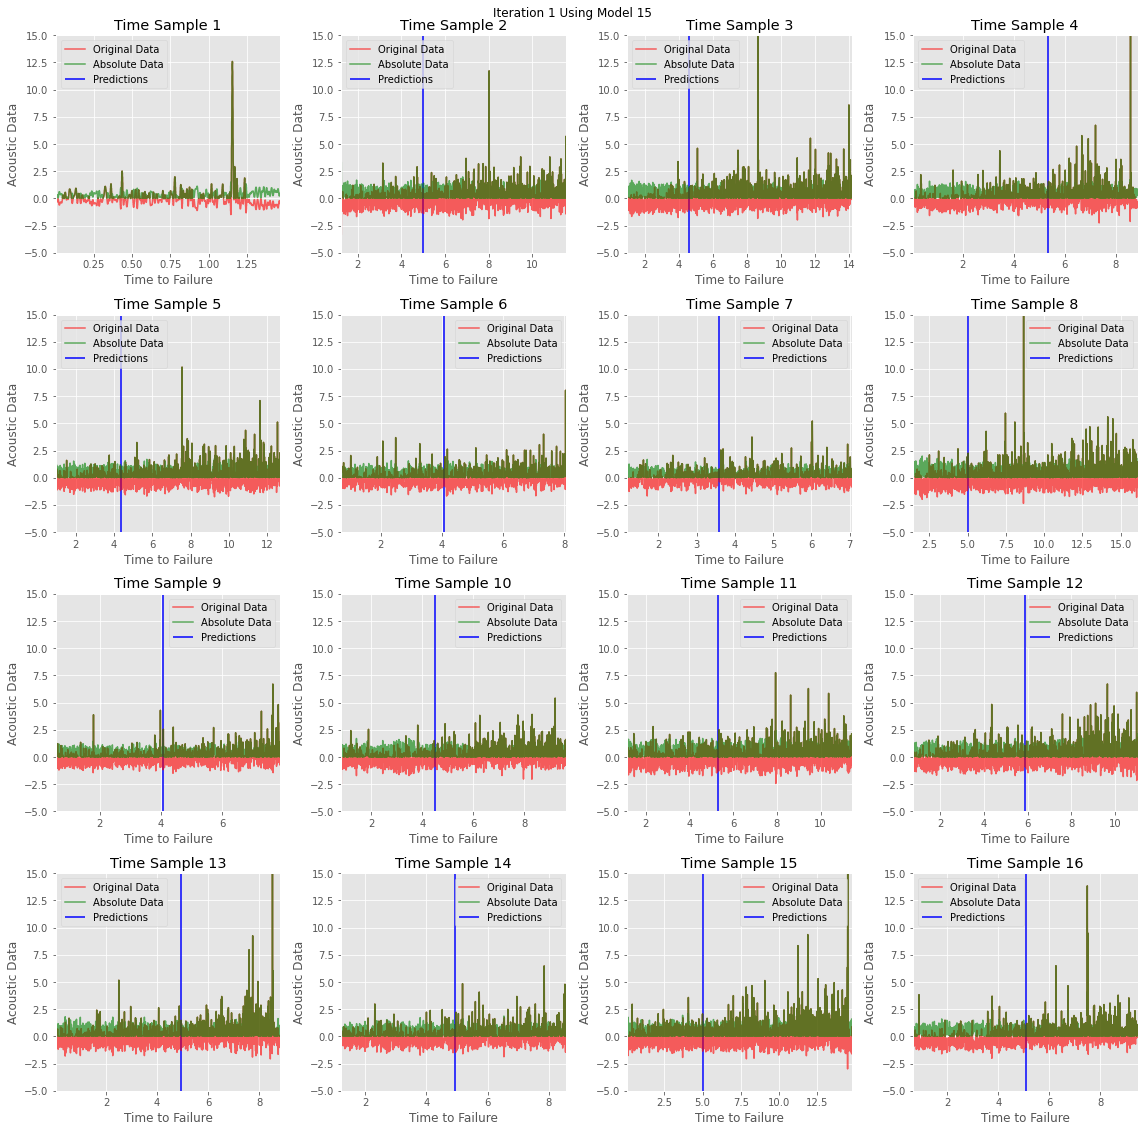

0.39587547805259704
3


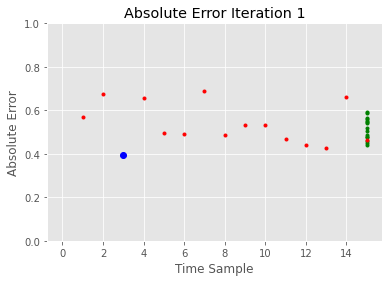

1/1 [==============================] - 0s 16ms/step


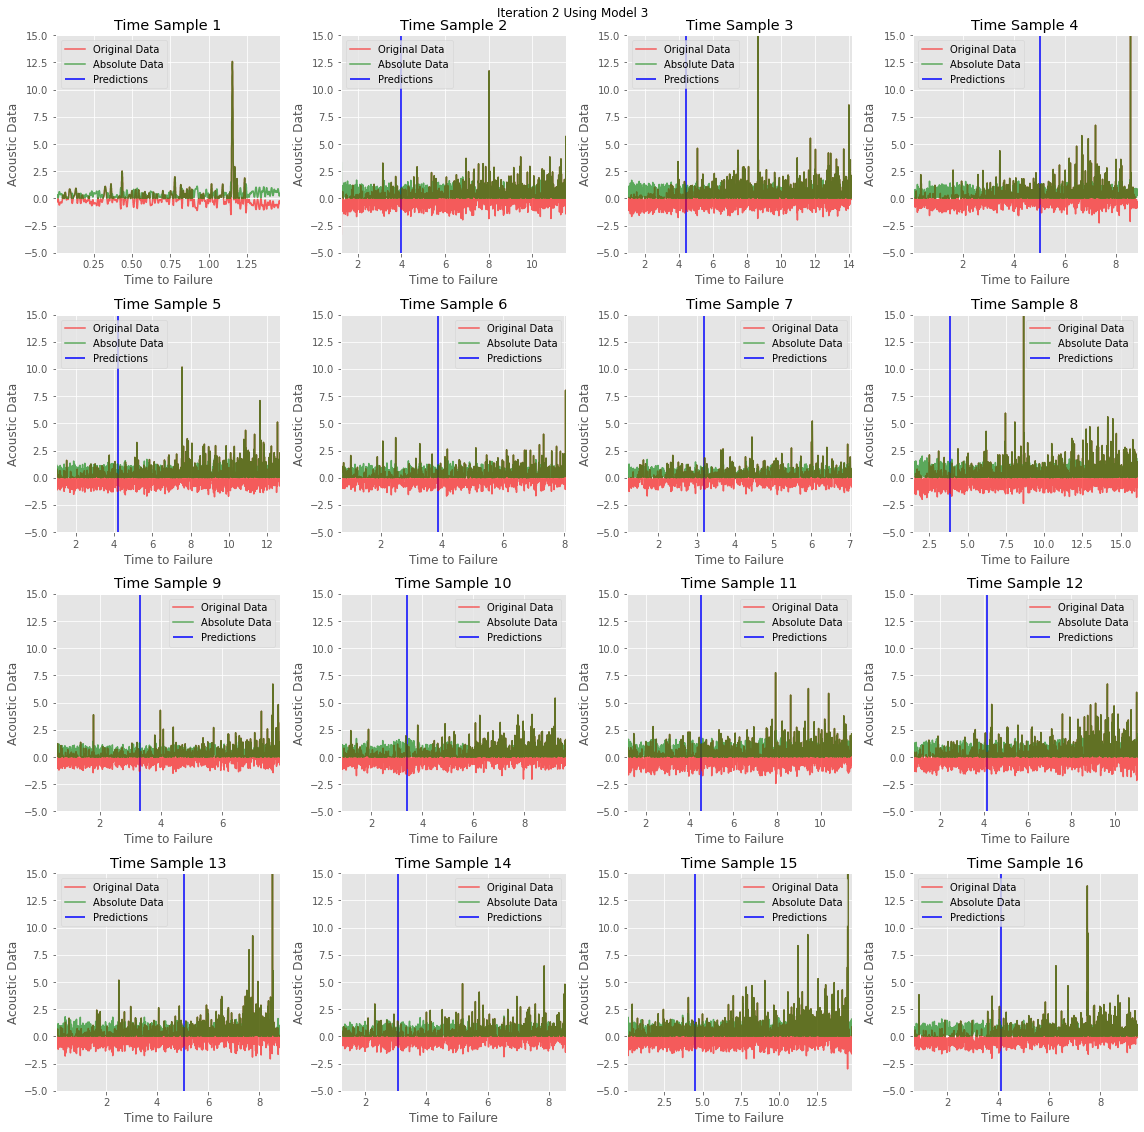

0.4297424651164387
12


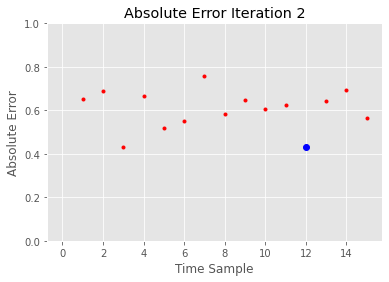

1/1 [==============================] - 0s 15ms/step


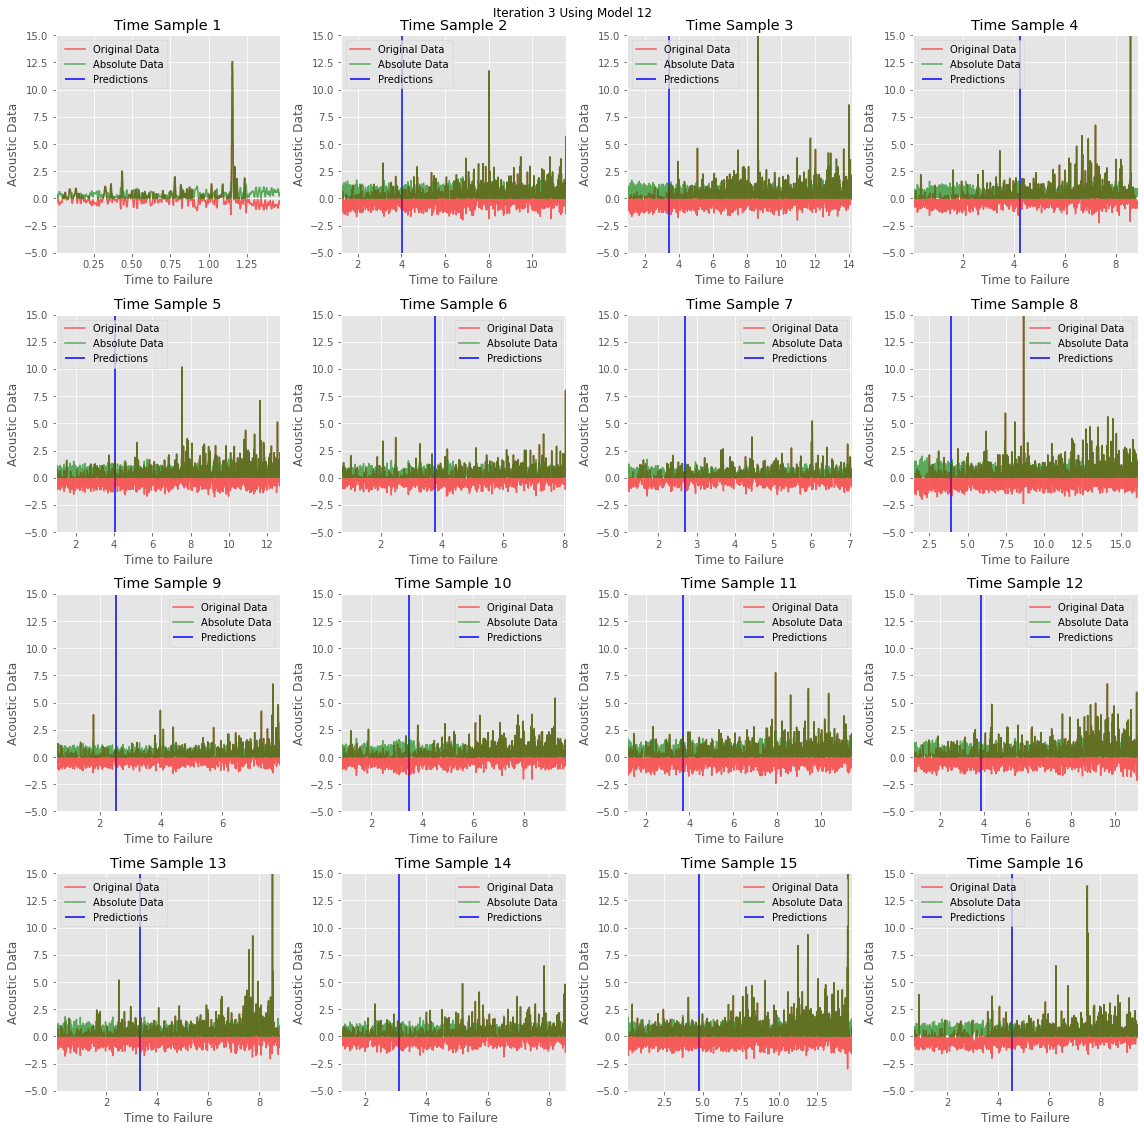

3 0.5183481834564087
3


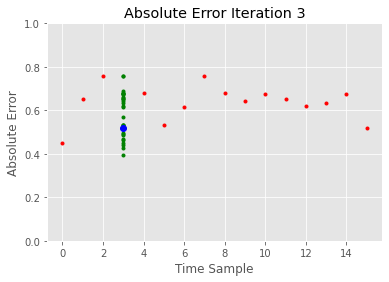

1/1 [==============================] - 0s 15ms/step


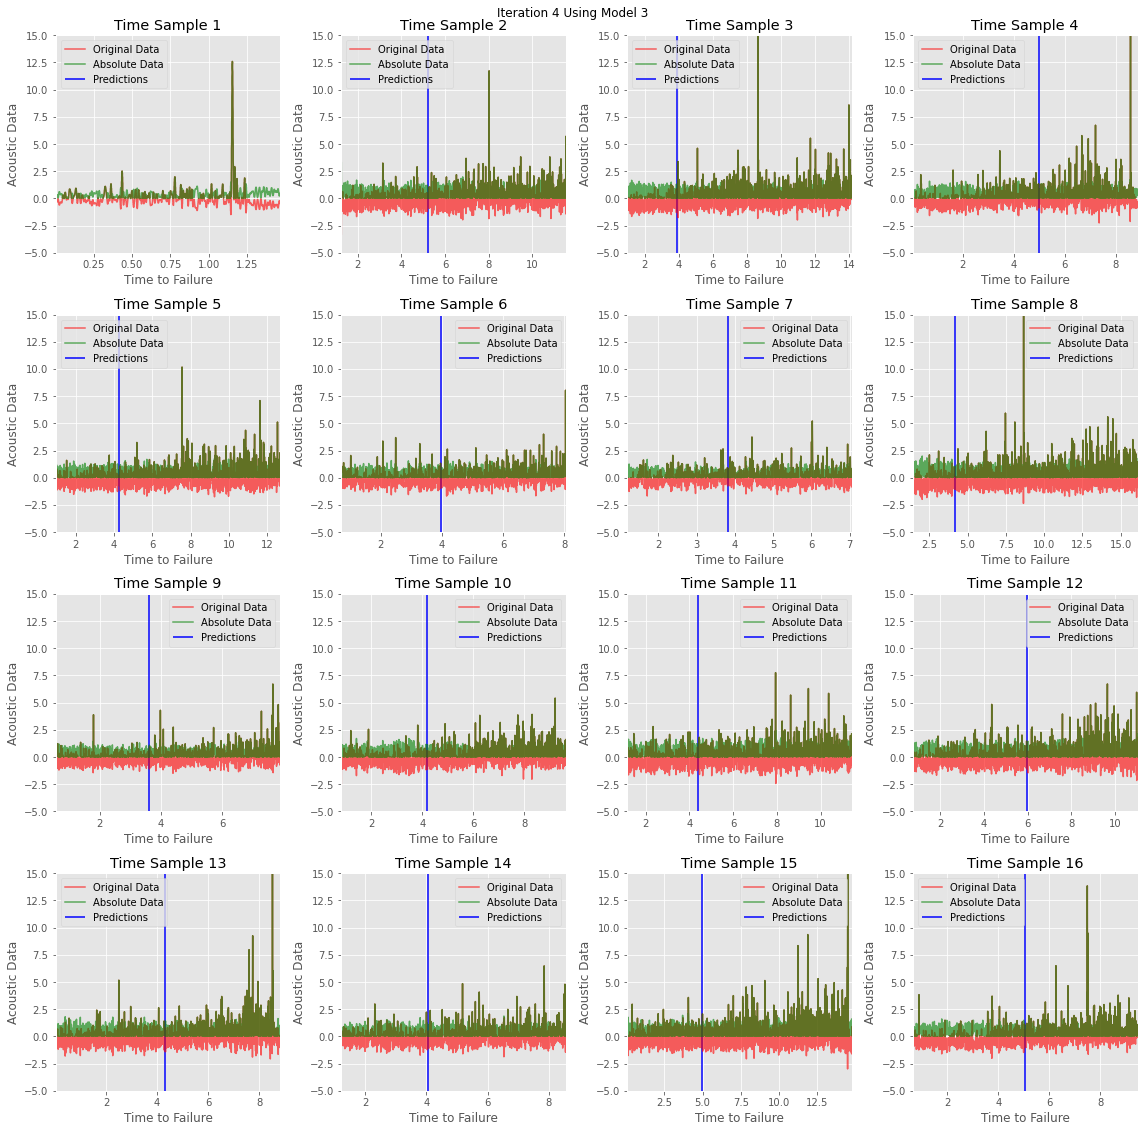

0.43704659882842595
3


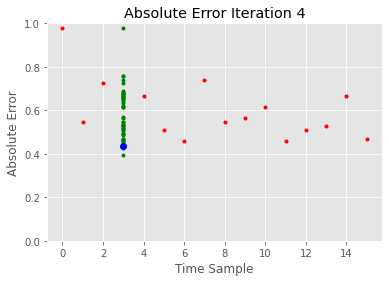

1/1 [==============================] - 0s 15ms/step


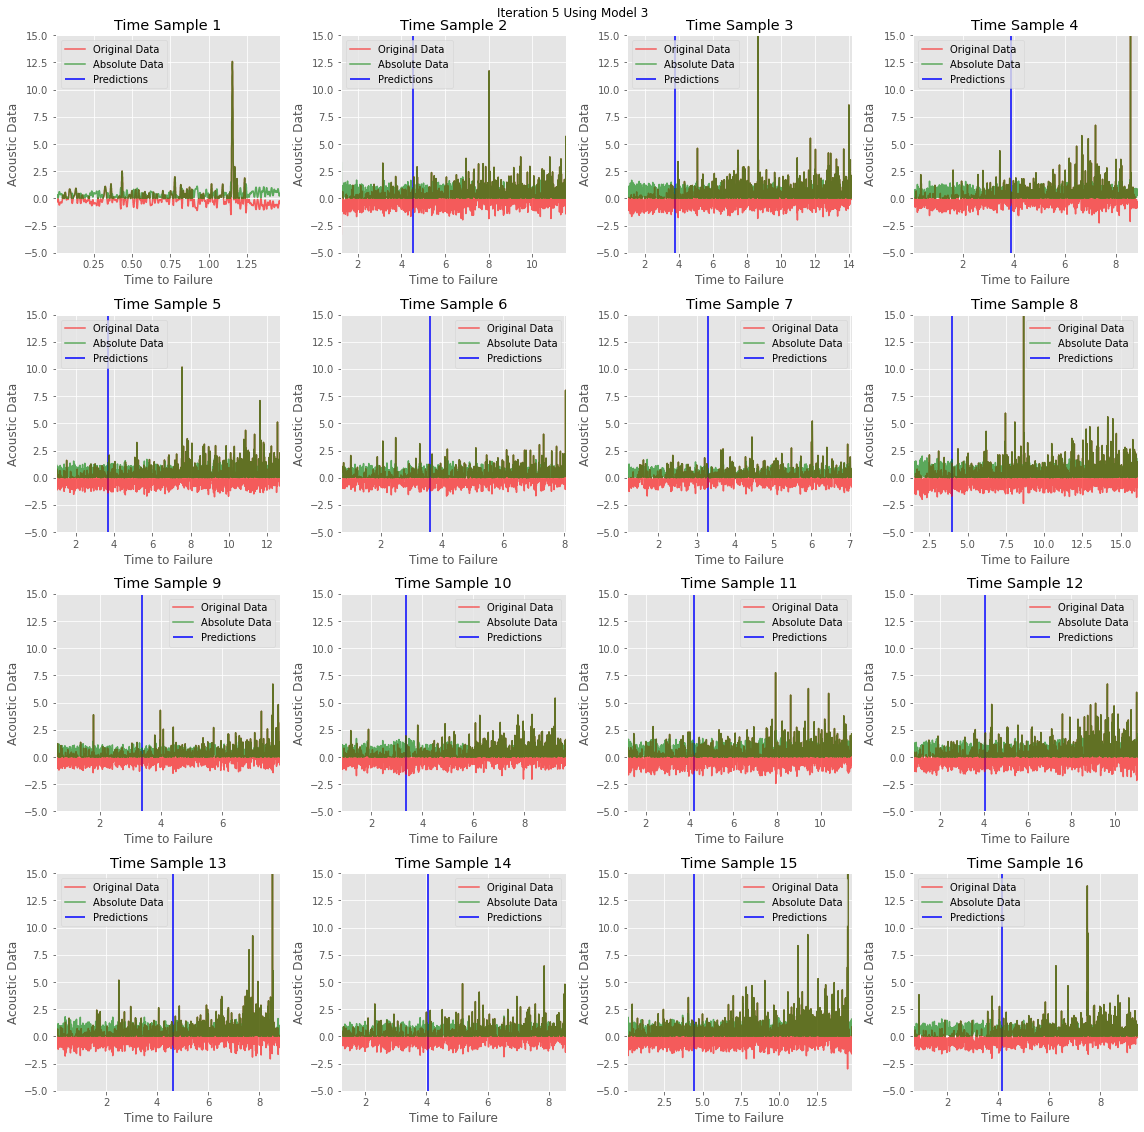

0.478357269000939
12


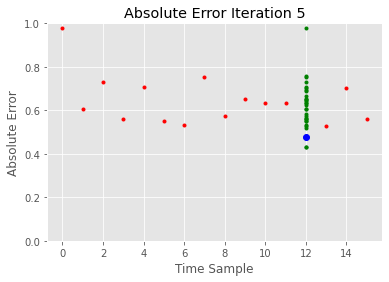

1/1 [==============================] - 0s 26ms/step


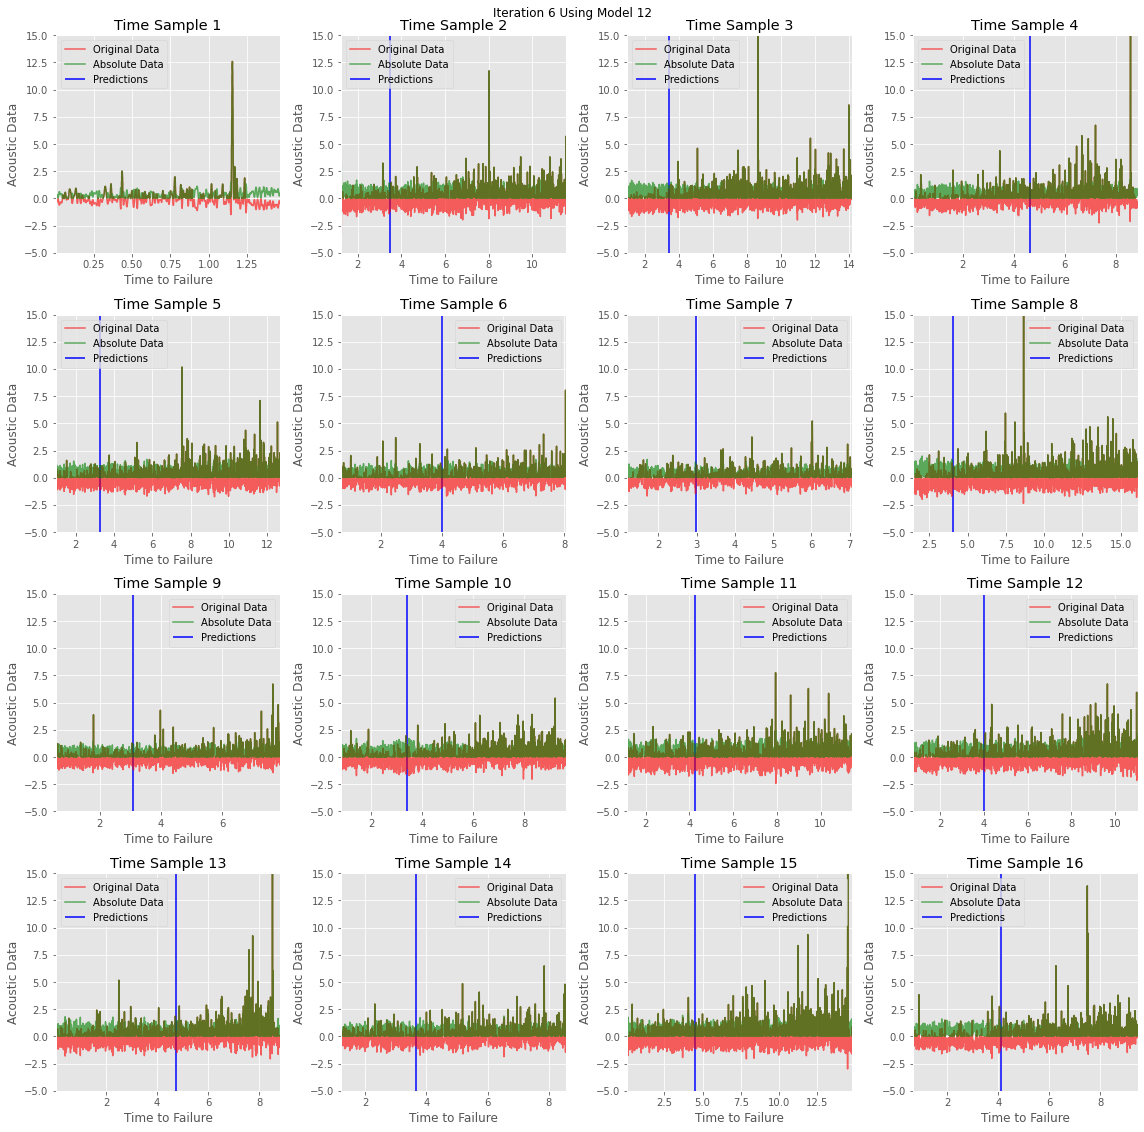

0.46547984023168715
12


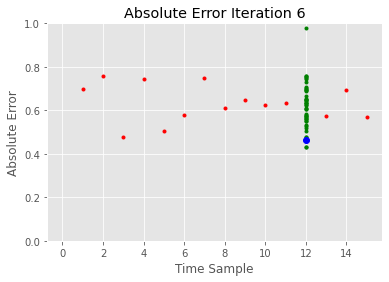

1/1 [==============================] - 0s 16ms/step


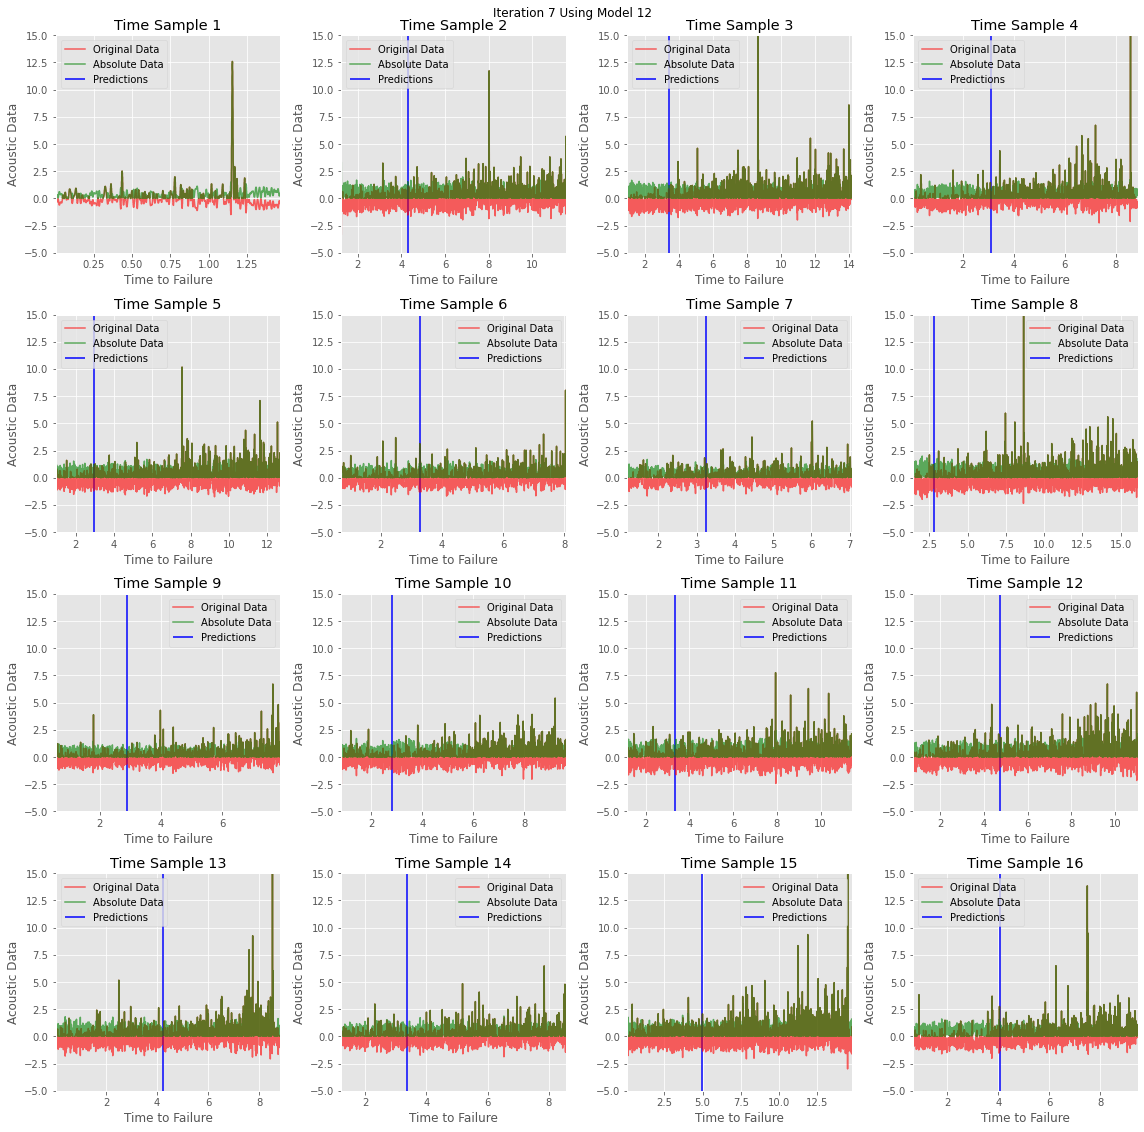

0.5209546373247174
12


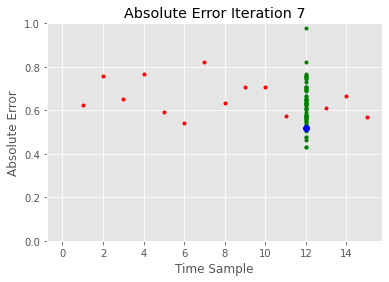

1/1 [==============================] - 0s 15ms/step


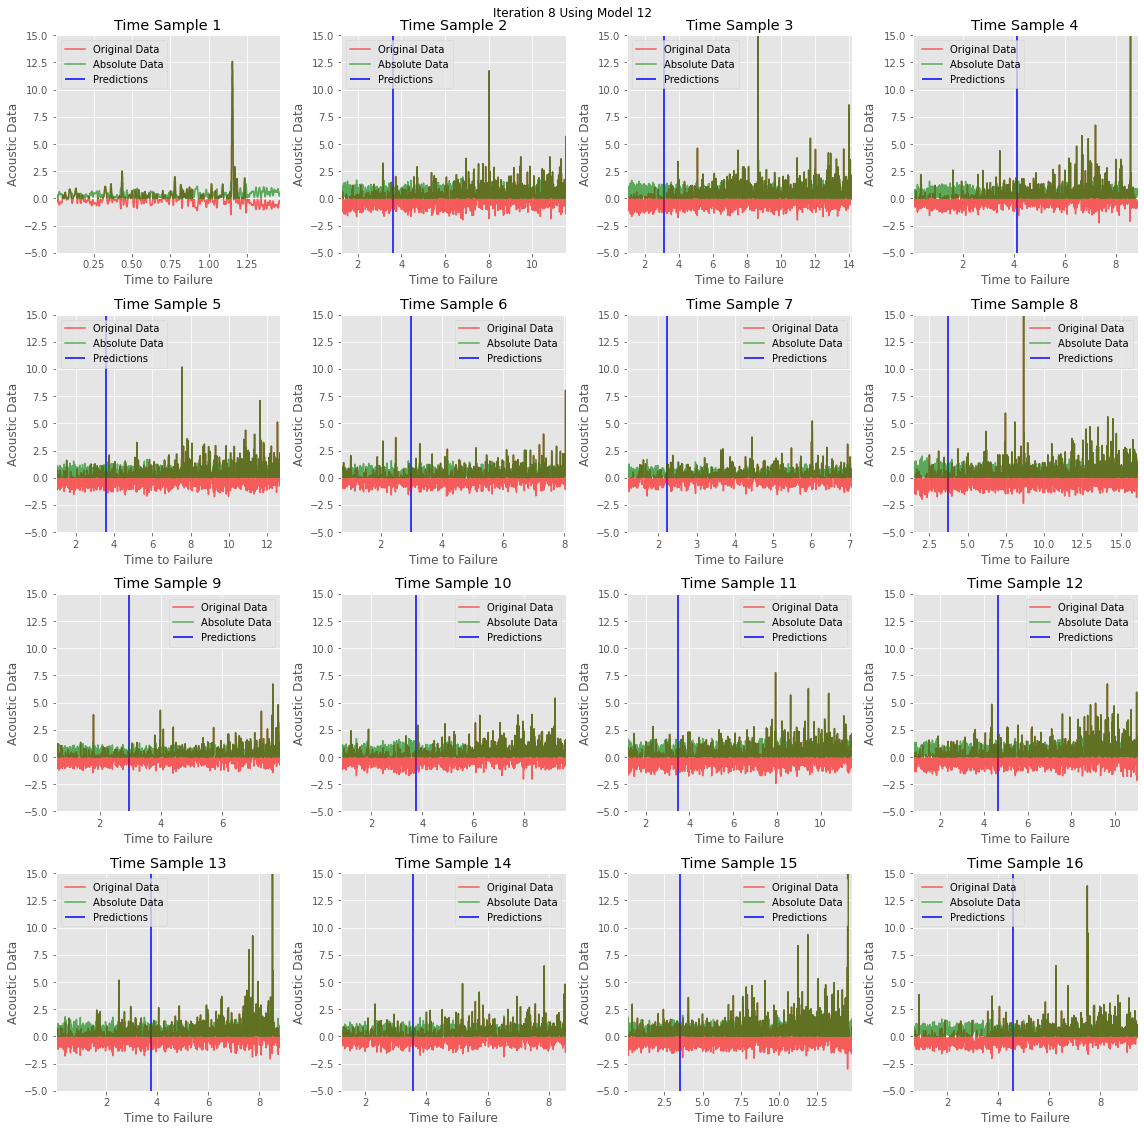

0.5163682620372183
15


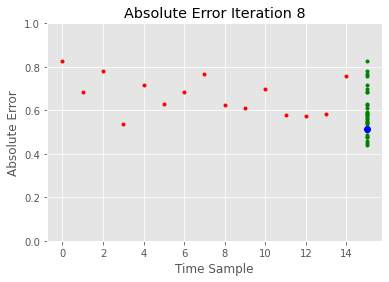

1/1 [==============================] - 0s 14ms/step


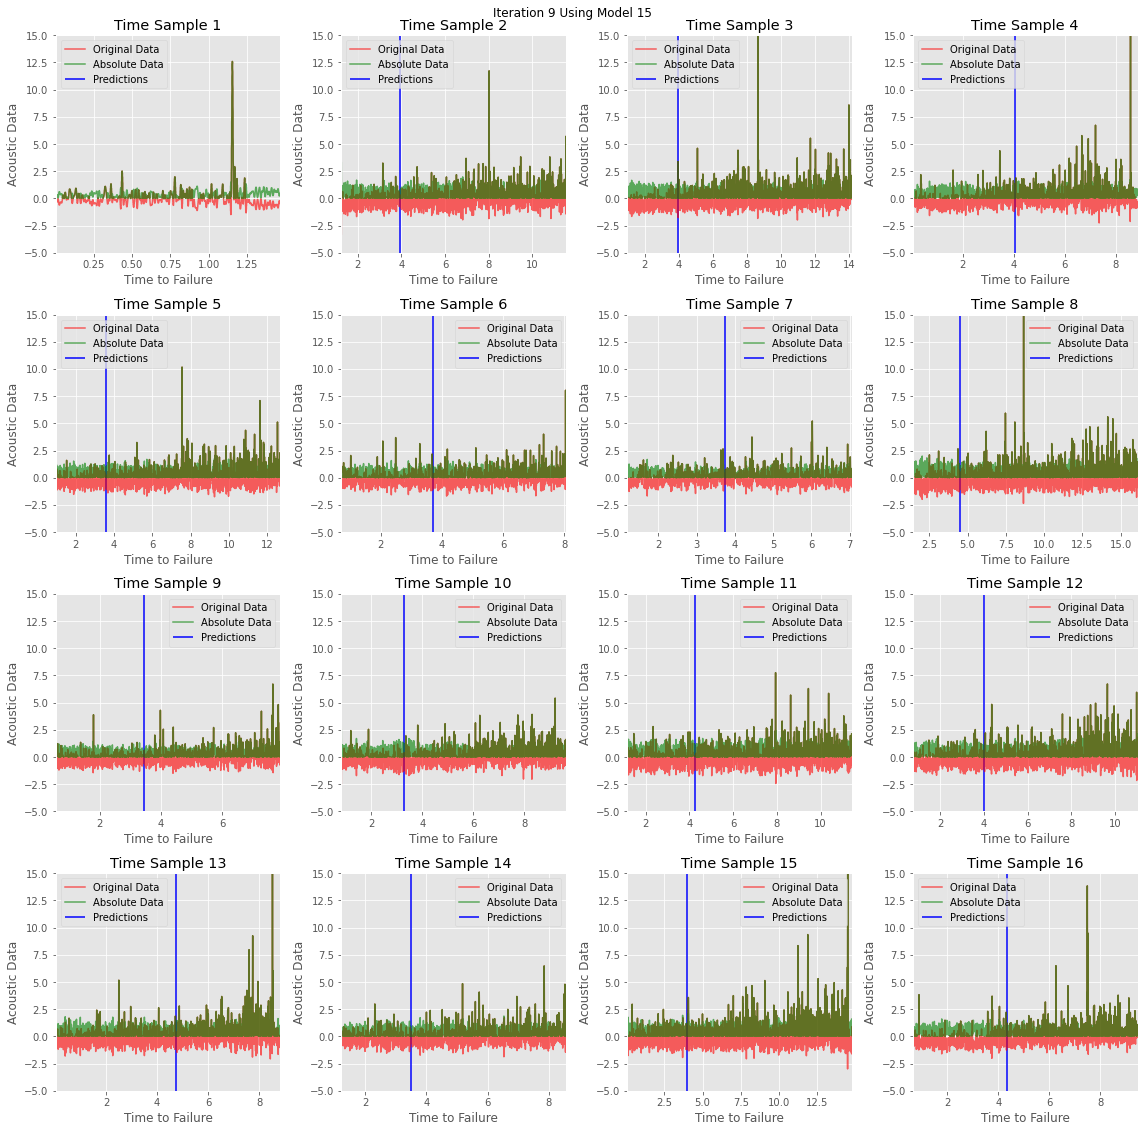

0.4650219132018701
12


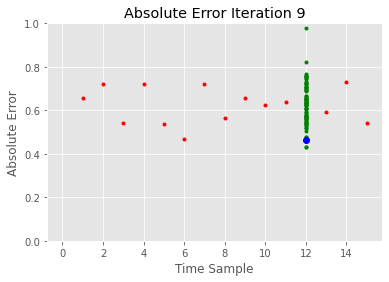

1/1 [==============================] - 0s 15ms/step


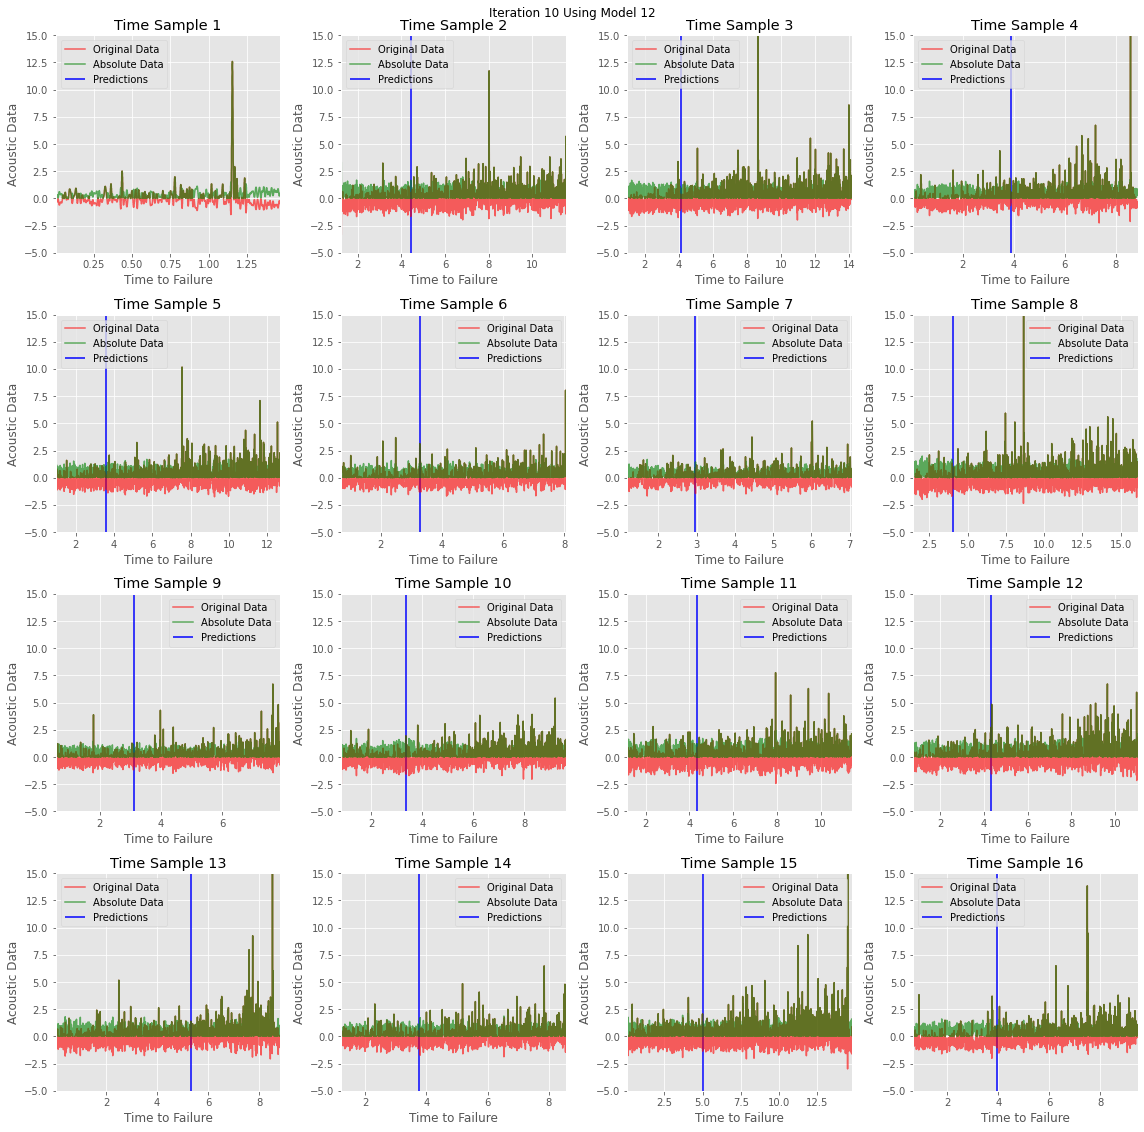

0.3965762978804522
12


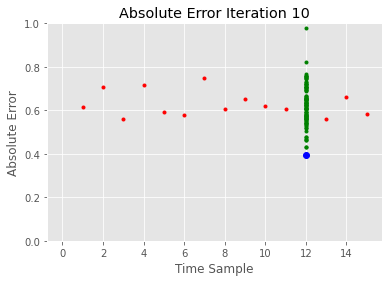

1/1 [==============================] - 0s 16ms/step


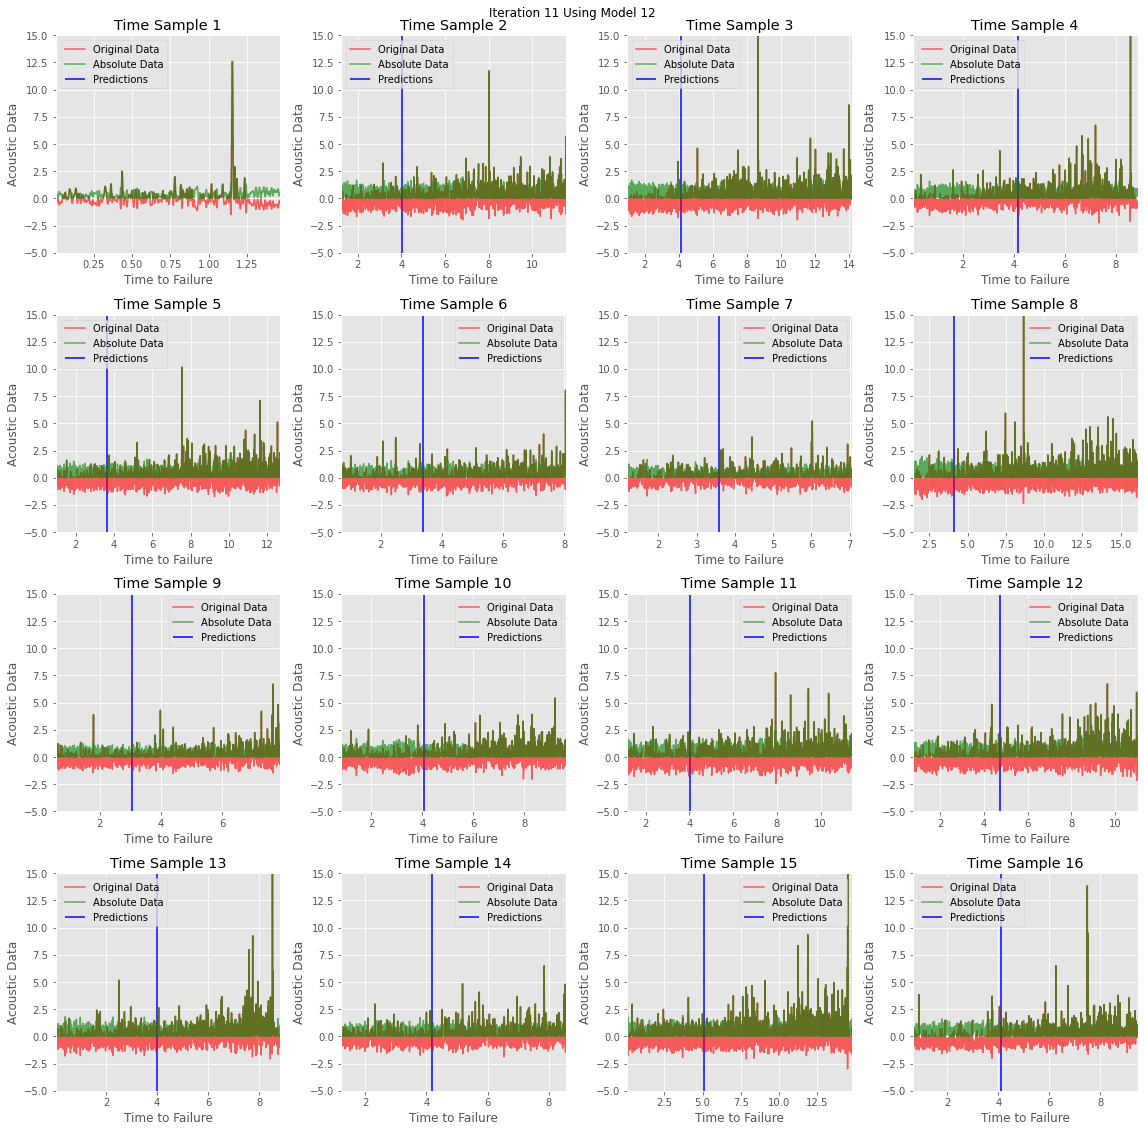

0.49311217535761626
6


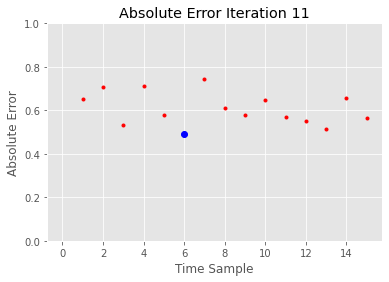

1/1 [==============================] - 0s 15ms/step


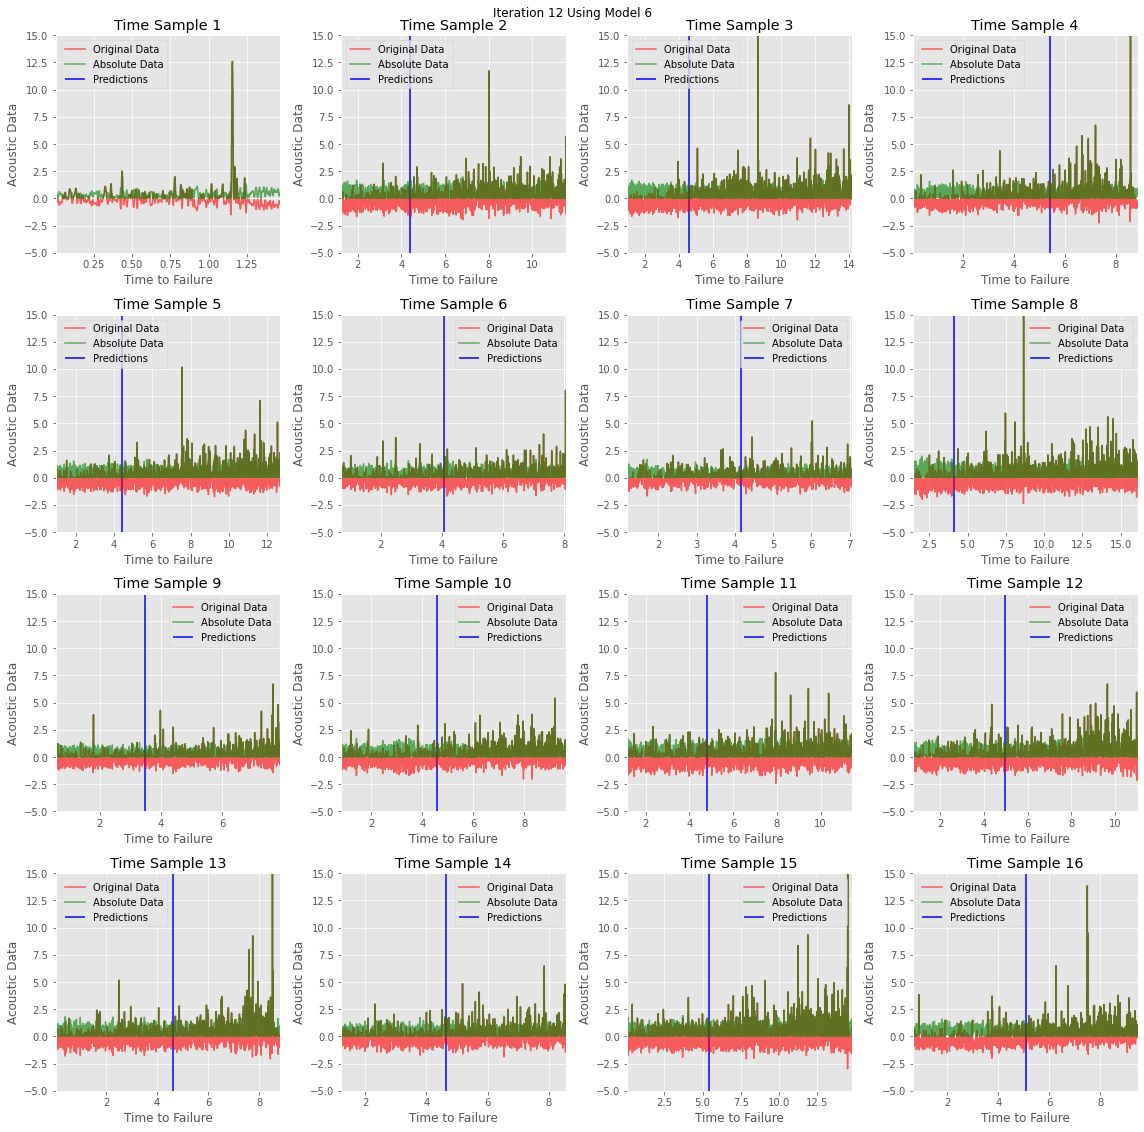

0.38592751069260317
3


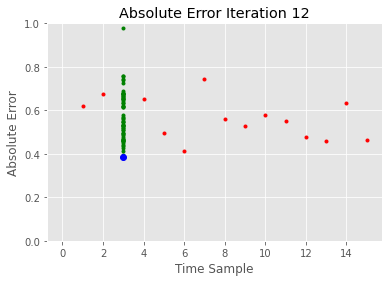

1/1 [==============================] - 0s 15ms/step


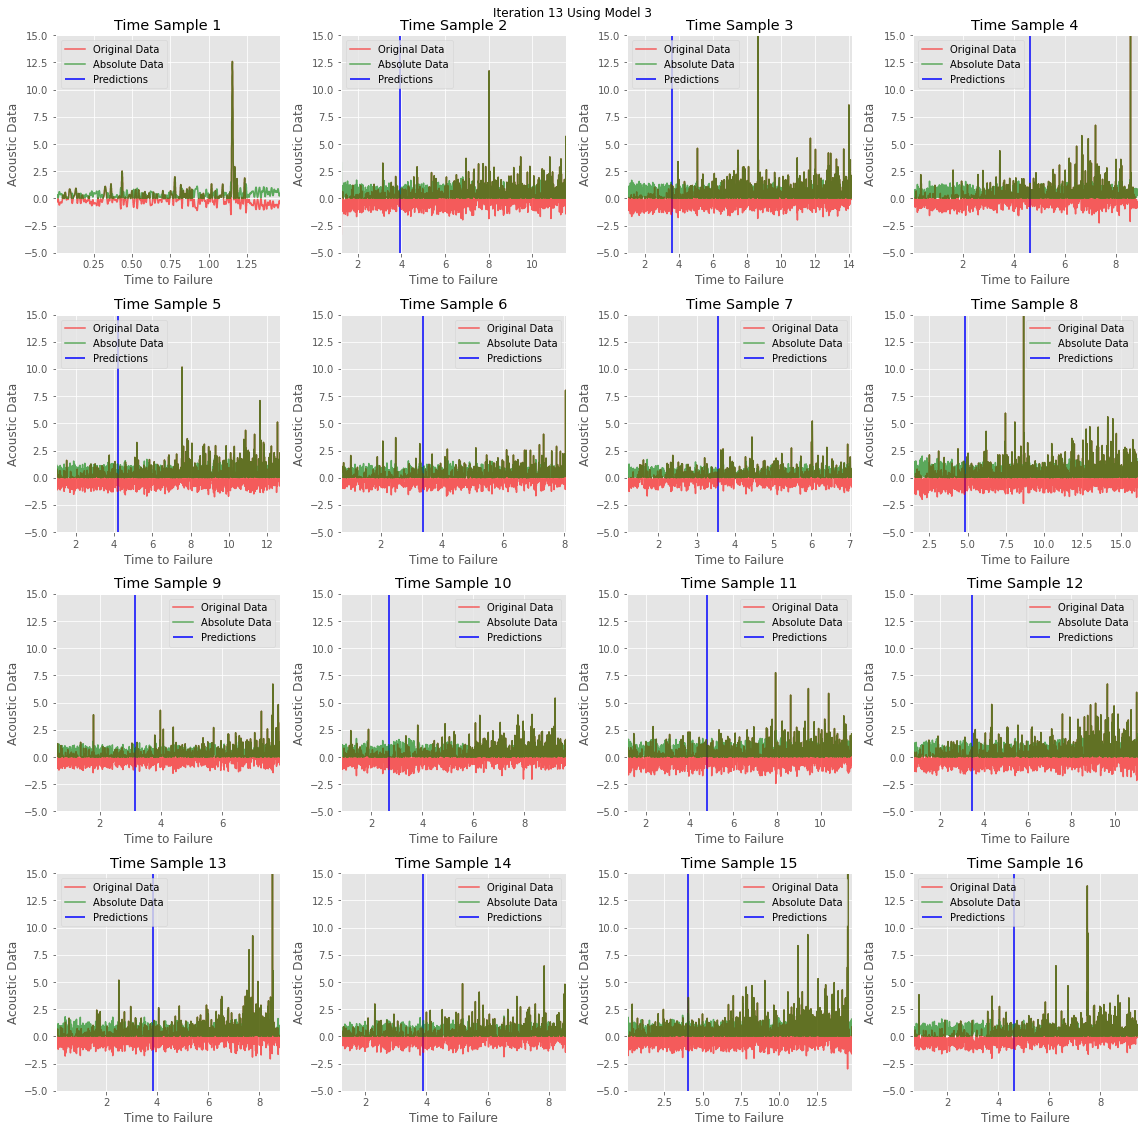

0.47650385795329764
3


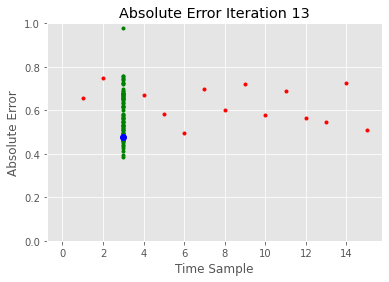

1/1 [==============================] - 0s 15ms/step


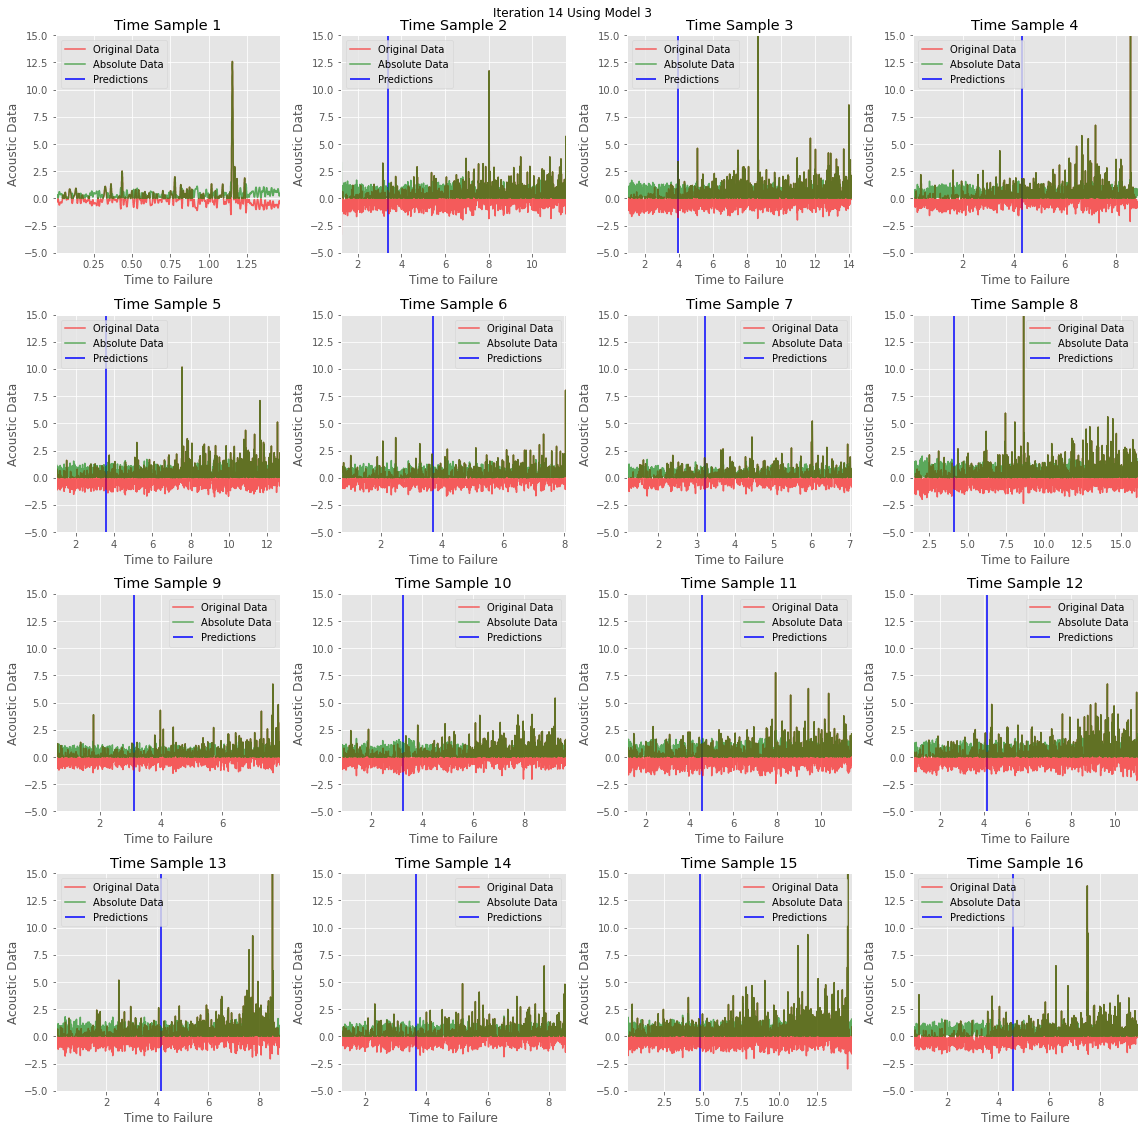

0.5095480129279029
3


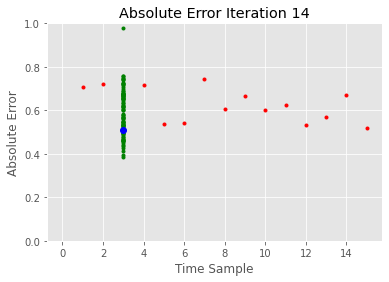

1/1 [==============================] - 0s 15ms/step


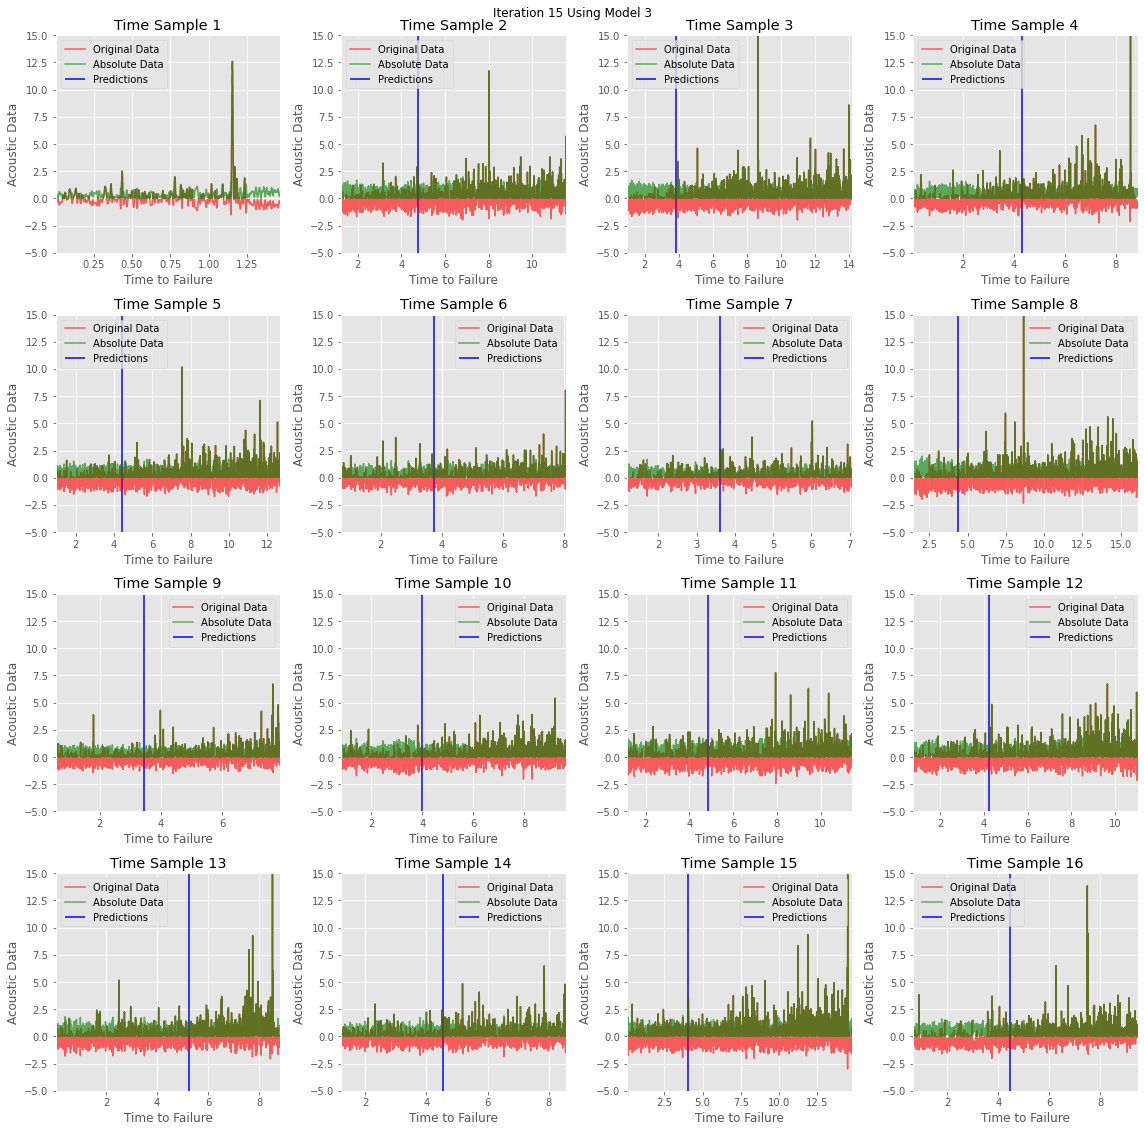

0.40801464315649616
12


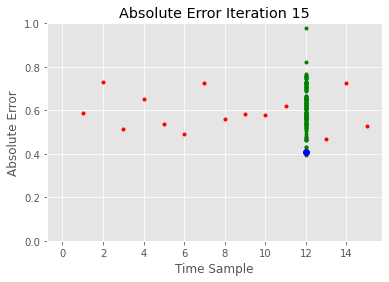

1/1 [==============================] - 0s 16ms/step


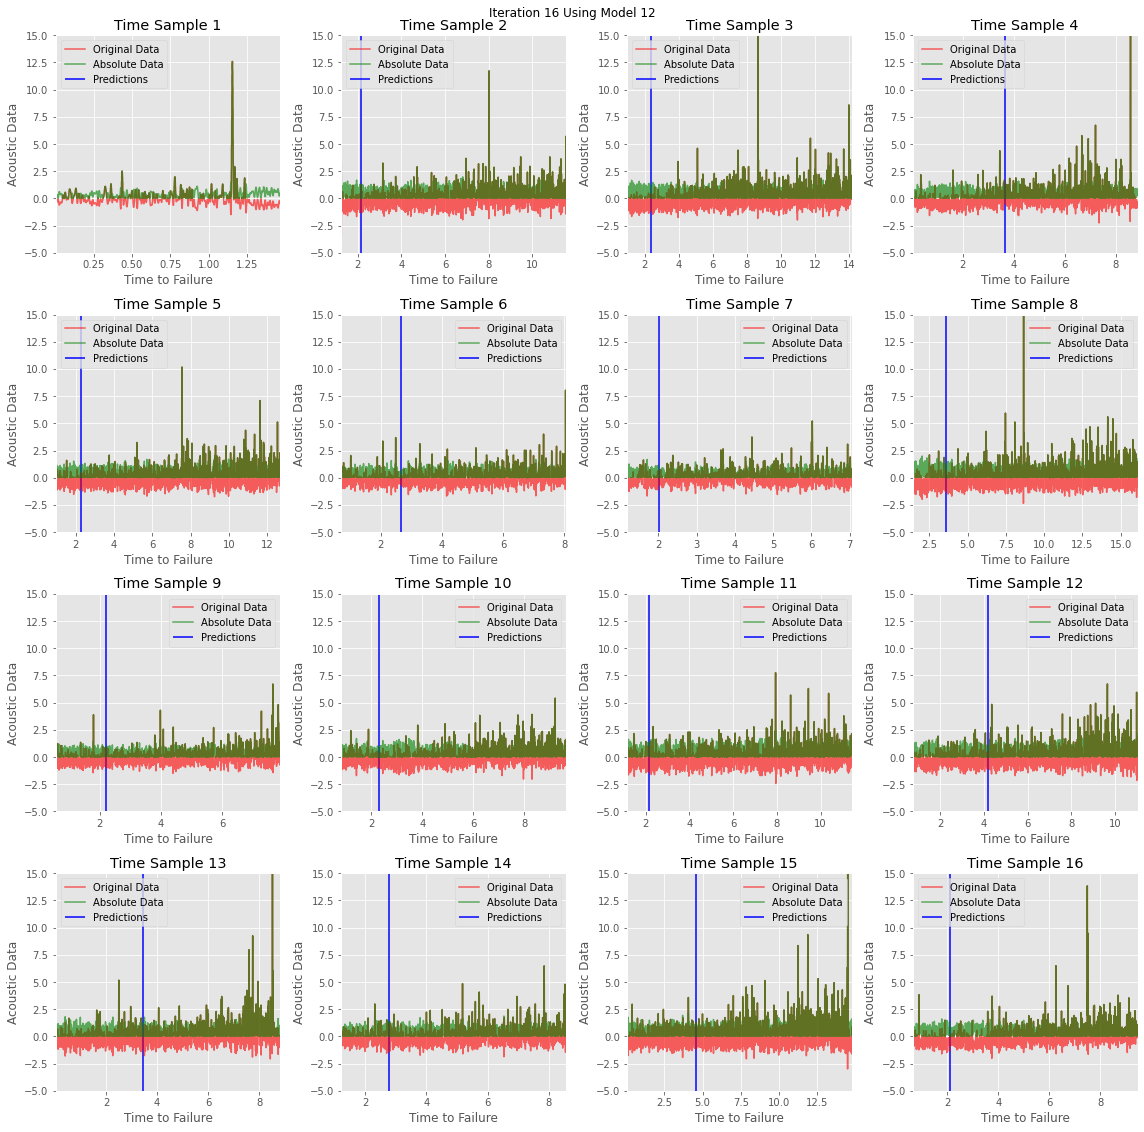

0.5868952196920488
3


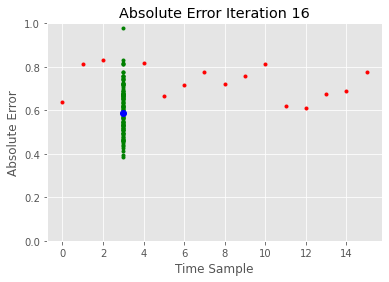

1/1 [==============================] - 0s 15ms/step


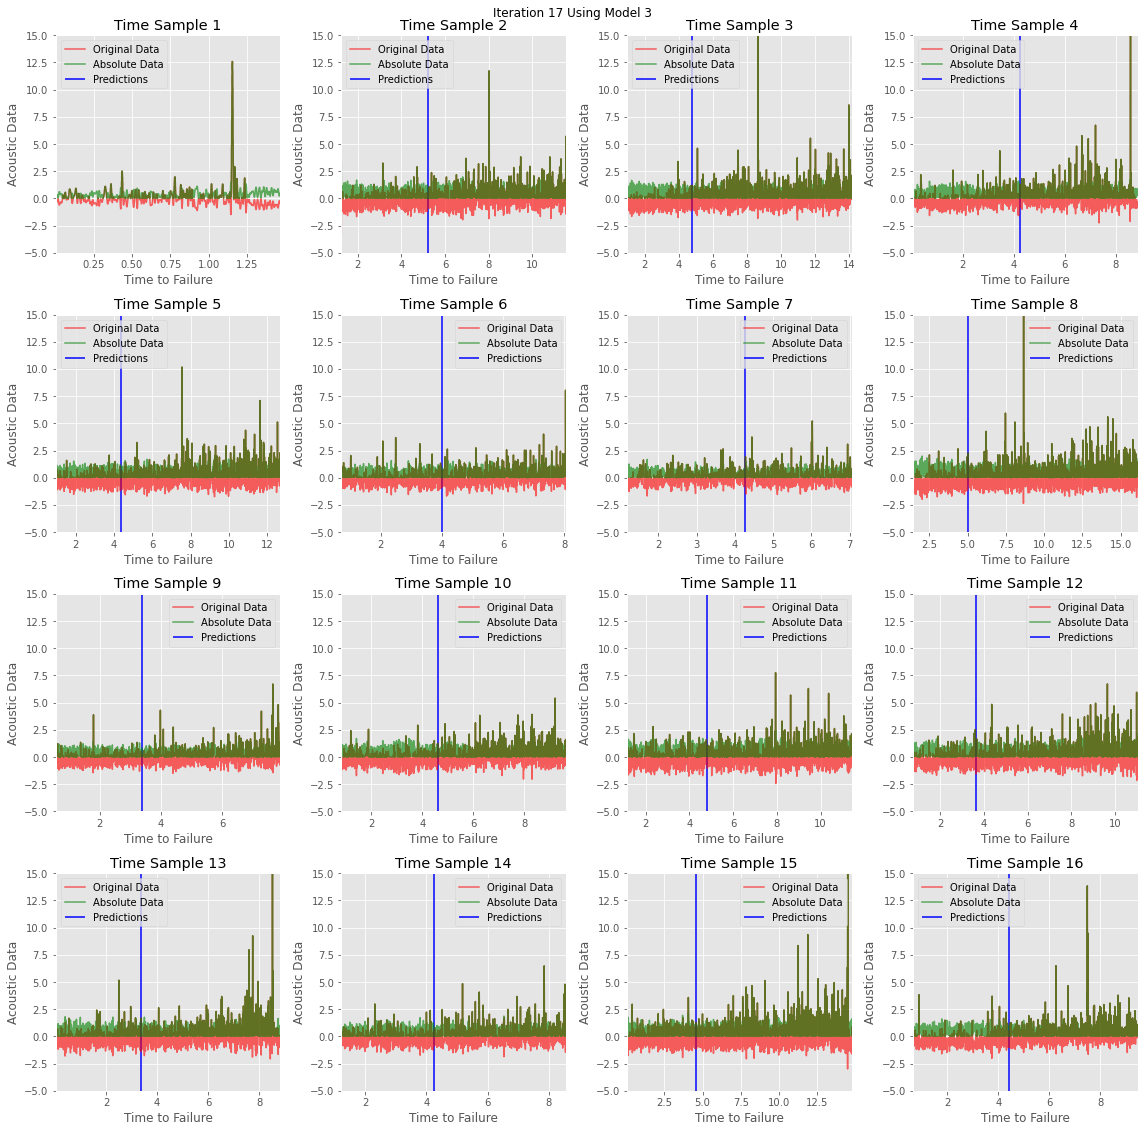

0.39443474236839593
6


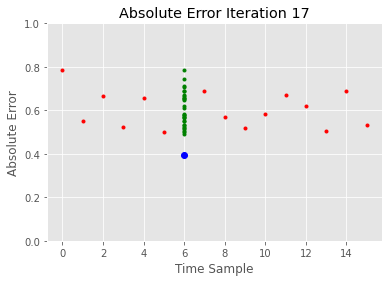

1/1 [==============================] - 0s 23ms/step


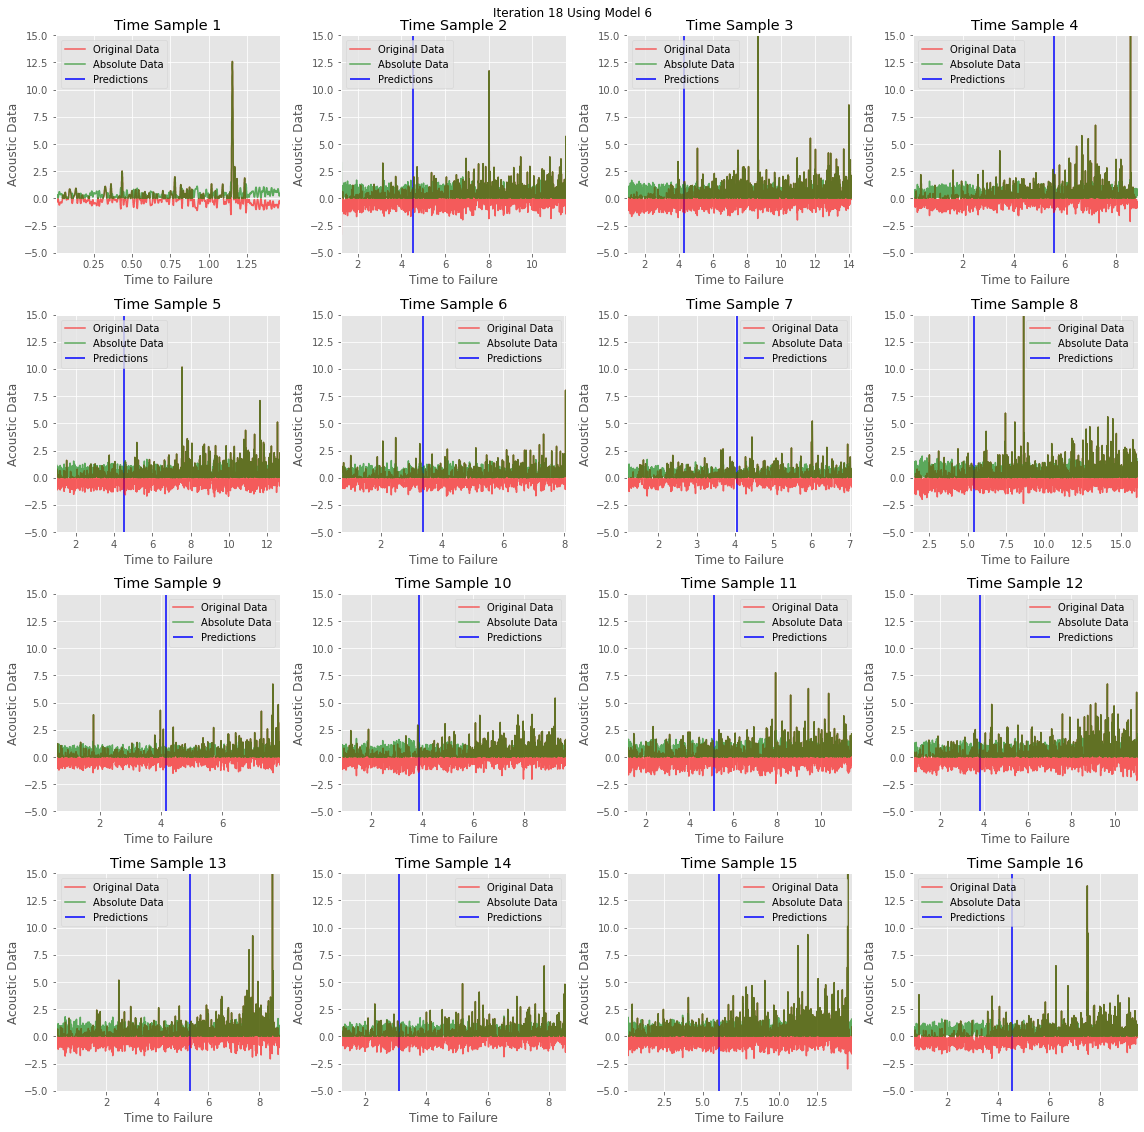

0.37208638058193
3


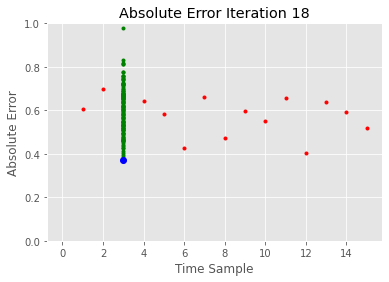

1/1 [==============================] - 0s 14ms/step


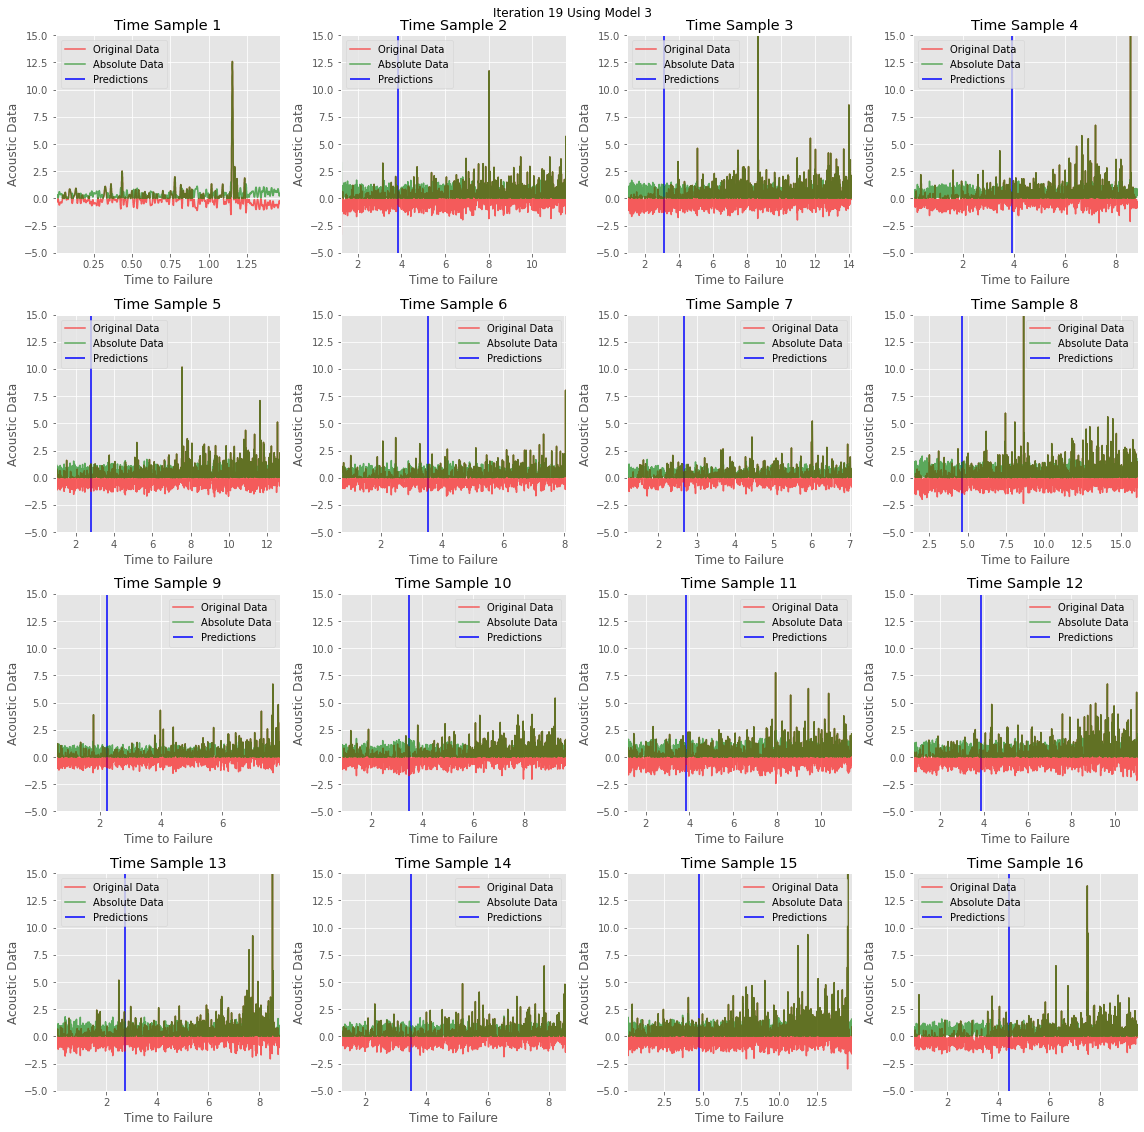

0.5349032384819267
15


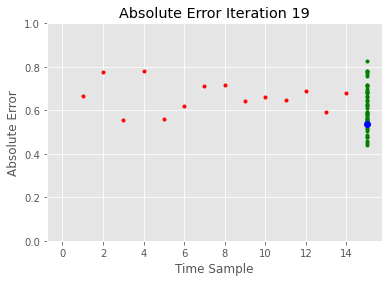

1/1 [==============================] - 0s 15ms/step


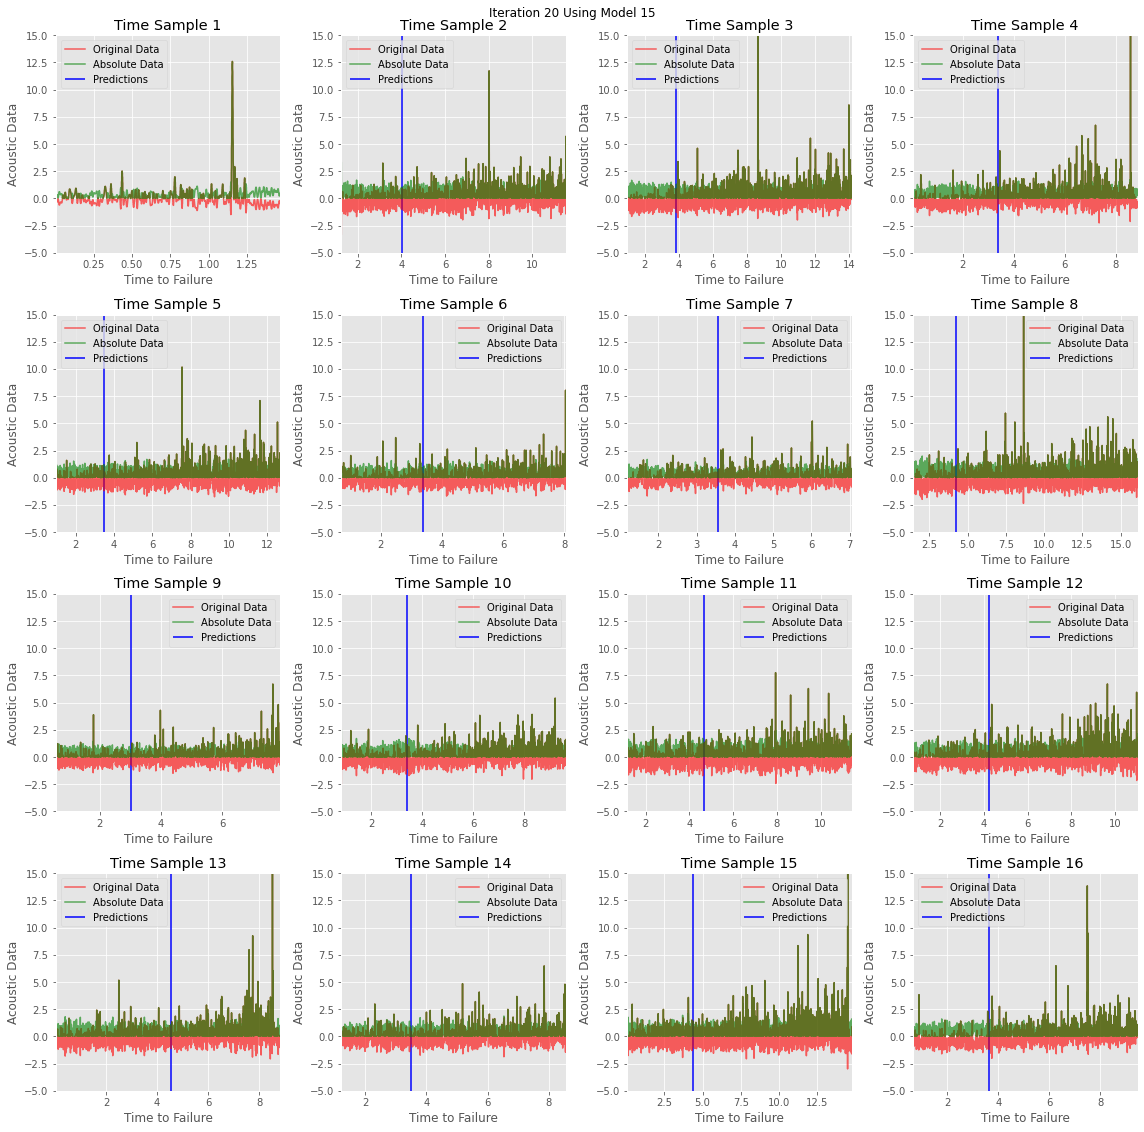

0.4841429863547825
12


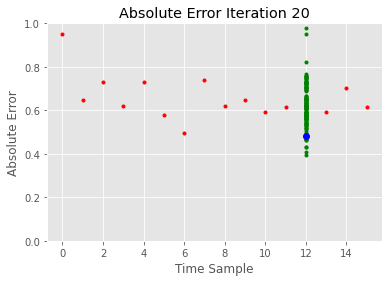

In [11]:
def find_abs_err_min(pred_arr, true_arr):
    absolute_errors = [abs(pred - true)/true for pred, true in zip(pred_arr, true_arr)]
    min_index = np.argmin(absolute_errors)
    smallest = min(absolute_errors)
    if min_index == 0:
        second_smallest_num = float('inf')  # Initialize with positive infinity
    
        # Iterate through the array
        for num in absolute_errors:
            if num < second_smallest_num and num != smallest:
                second_smallest_num = num
                second_smallest_ind = absolute_errors.index(num)
                
        min_index = second_smallest_ind
        print(min_index, second_smallest_num)
    else:
        print(absolute_errors[min_index])
        pass

    return min_index, absolute_errors


def NN_iter_mult(data1, data2, num_samples, name_array, err_name_array):
    pred_arr, true_arr = NN_test(data1, data2, num_samples)
    
    ideal_model_index, abs_error1 = find_abs_err_min(pred_arr, true_arr)
    ideal_model_index_arr = [ideal_model_index]
    tally_dict = {}
    print(ideal_model_index)
    tally_dict[ideal_model_index] = abs_error1
    plt.plot(abs_error1, 'r.')
    plt.plot(ideal_model_index, abs_error1[ideal_model_index], 'bo')
    plt.xlabel('Time Sample')
    plt.ylabel('Absolute Error')
    plt.title('Time Sample AE')
    plt.ylim(0,1)
    plt.savefig('Initial_err_graph')
    plt.show()
    
    for i in range(20):
        if i == 0:
            pred_arr, true_arr = NN_iterate(data1, data2, num_samples, ideal_model_index, name_array[i], i+1)
            ideal_model_index_iter, abs_error2 = find_abs_err_min(pred_arr, true_arr)
            ideal_model_index_arr.append(ideal_model_index_iter)
            if ideal_model_index_iter in tally_dict:
                tally_dict[ideal_model_index_iter] += abs_error2
            else:
                tally_dict[ideal_model_index_iter] = abs_error2
            print(ideal_model_index_iter)
            plt.plot(ideal_model_index * np.ones((len(tally_dict[ideal_model_index]))),tally_dict[ideal_model_index], 'g.')
            plt.plot(abs_error2, 'r.')
            plt.plot(ideal_model_index_iter, abs_error2[ideal_model_index_iter], 'bo')
            plt.xlabel('Time Sample')
            plt.ylabel('Absolute Error')
            plt.title('Absolute Error Iteration ' + str(i+1))
            plt.ylim(0,1)
            plt.savefig(err_name_array[i])
            plt.show()
        else:
            pred_arr, true_arr = NN_iterate(data1, data2, num_samples, ideal_model_index_iter, name_array[i], i+1)
            ideal_model_index_iter, abs_error3 = find_abs_err_min(pred_arr, true_arr)
            ideal_model_index_arr.append(ideal_model_index_iter)
            if ideal_model_index_iter in tally_dict:
                tally_dict[ideal_model_index_iter] += abs_error3
            else:
                tally_dict[ideal_model_index_iter] = abs_error3
            print(ideal_model_index_iter)
            if len(tally_dict[ideal_model_index_iter]) > 16:
                plt.plot(ideal_model_index_iter * np.ones((len(tally_dict[ideal_model_index_iter]))),tally_dict[ideal_model_index_iter], 'g.')
            plt.plot(abs_error3, 'r.')
            plt.plot(ideal_model_index_iter, abs_error3[ideal_model_index_iter], 'bo')
            plt.xlabel('Time Sample')
            plt.ylim(0,1)
            plt.ylabel('Absolute Error')
            plt.title('Absolute Error Iteration ' +str(i+1))
            plt.savefig(err_name_array[i])
            plt.show()
            
    return pred_arr, true_arr, abs_error3, ideal_model_index_arr, tally_dict


num_graphs = 100
extended_graph_names = [f'graph{i+1}' for i in range(num_graphs)]

err_graph_names = [f'{name}_err' for name in extended_graph_names]

pred_arr, true_arr, error_final, ideal_arr, tally_err_dict = NN_iter_mult(df["time_to_failure"], df['acoustic_data'], 16, extended_graph_names, err_graph_names)

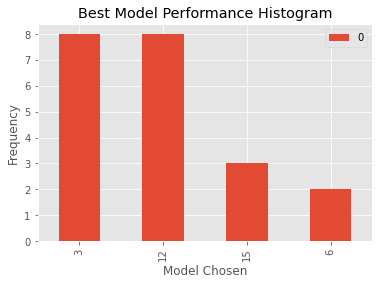

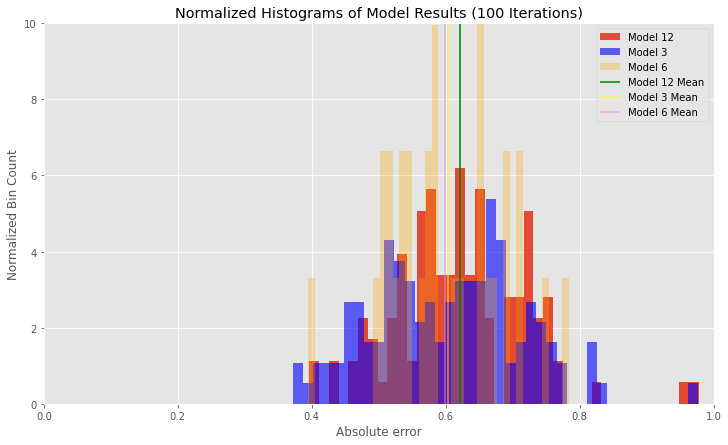

In [16]:
def tally_repetitions(array):
    tally = defaultdict(int)
    for element in array:
        tally[element] += 1
    return tally

# Example usage:
repetitions = tally_repetitions(ideal_arr)
sorted_repetitions = dict(sorted(repetitions.items(), key=lambda x: x[1], reverse=True))

rep_df = pd.DataFrame.from_dict(sorted_repetitions, orient='index')

# Plot the histogram
rep_df.plot( kind = 'bar')

# Add labels and title
plt.xlabel('Model Chosen')
plt.ylabel('Frequency')
plt.title('Best Model Performance Histogram')

# Show plot
plt.show()

filtered_list12 = [num for num in tally_err_dict[12] if num <= 1]
filtered_list3 = [num for num in tally_err_dict[3] if num <= 1]
filtered_list6 = [num for num in tally_err_dict[6] if num <= 1]

mean_value12 = np.mean(filtered_list12)
std_dev12 = statistics.stdev(filtered_list12)

mean_value3 = np.mean(filtered_list3)
std_dev3 = statistics.stdev(filtered_list3)

mean_value6 = np.mean(filtered_list6)
std_dev6 = statistics.stdev(filtered_list6)

plt.figure(figsize = (12,7))
plt.hist(filtered_list12, bins = 40, label = 'Model 12', density = True)
plt.vlines(mean_value12, 0, 200, color = 'green', label = 'Model 12 Mean')
plt.hist(filtered_list3, bins = 40, color = 'blue', label = 'Model 3', density = True, alpha = .6)
plt.vlines(mean_value3, 0,200, color = 'yellow', label = 'Model 3 Mean', alpha = .6)
plt.hist(filtered_list6, bins = 40, color = 'orange', label = 'Model 6', density = True, alpha = .3)
plt.vlines(mean_value6, 0,200, color = 'violet', label = 'Model 6 Mean', alpha = .6)
plt.xlim(0,1)
plt.ylim(0, 10)
plt.title('Normalized Histograms of Model Results (100 Iterations)')
plt.xlabel('Absolute error')
plt.ylabel('Normalized Bin Count')

plt.legend()
plt.show()

In [18]:
csv_files = [file for file in os.listdir('./test') if file.startswith('seg') and file.endswith('.csv')]
print(len(csv_files))

2624


MovieWriter imagemagick unavailable; using Pillow instead.


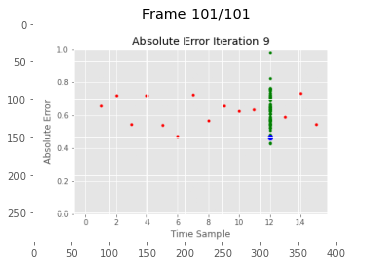

In [25]:
# Path to the directory containing the images
images_dir = './Error Graphs/Test 4'

# Get the list of image files
image_files = sorted([os.path.join(images_dir, file) for file in os.listdir(images_dir) if file.endswith('.png')])

# Create a figure and axis
fig, ax = plt.subplots()

# Function to update the animation
def update(frame):
    ax.clear()
    ax.imshow(plt.imread(image_files[frame]))
    ax.set_title(f'Frame {frame + 1}/{len(image_files)}')

# Create the animation
animation = FuncAnimation(fig, update, frames=len(image_files), interval=100)

# Save the animation as a GIF
animation.save('animation_err.gif', writer='imagemagick')

In [20]:
def move_files_with_err(source_folder, destination_folder):
    # Ensure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Iterate through files in the source folder
    for filename in os.listdir(source_folder):
        if "graph" in filename:
            # Construct full paths for source and destination
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder, filename)
            
            # Move the file to the destination folder
            shutil.move(source_path, destination_path)
            print(f"Moved {filename} to {destination_folder}")

# Specify the source folder containing the files
source_folder = "./"

# Specify the destination folder to move files containing "err"
destination_folder = ".\Model Graphs\Test 4"

# Call the function to move files
move_files_with_err(source_folder, destination_folder)

Moved graph1.png to .\Model Graphs\Test 4
Moved graph10.png to .\Model Graphs\Test 4
Moved graph100.png to .\Model Graphs\Test 4
Moved graph11.png to .\Model Graphs\Test 4
Moved graph12.png to .\Model Graphs\Test 4
Moved graph13.png to .\Model Graphs\Test 4
Moved graph14.png to .\Model Graphs\Test 4
Moved graph15.png to .\Model Graphs\Test 4
Moved graph16.png to .\Model Graphs\Test 4
Moved graph17.png to .\Model Graphs\Test 4
Moved graph18.png to .\Model Graphs\Test 4
Moved graph19.png to .\Model Graphs\Test 4
Moved graph2.png to .\Model Graphs\Test 4
Moved graph20.png to .\Model Graphs\Test 4
Moved graph21.png to .\Model Graphs\Test 4
Moved graph22.png to .\Model Graphs\Test 4
Moved graph23.png to .\Model Graphs\Test 4
Moved graph24.png to .\Model Graphs\Test 4
Moved graph25.png to .\Model Graphs\Test 4
Moved graph26.png to .\Model Graphs\Test 4
Moved graph27.png to .\Model Graphs\Test 4
Moved graph28.png to .\Model Graphs\Test 4
Moved graph29.png to .\Model Graphs\Test 4
Moved graph3

Error: [('./Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs', '.\\Model Graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs\\Test 4\\Model graphs', "[WinError 206] The filename or extension is too long: '.\\\\Model Graphs\\\\Test 4\\\\Model graphs\\\\Test 4\\\\Model graphs\\\\Test 4\\\\Model graphs\\\\Test 4\\\\Model graphs\\\\Test 4\\\\Model graphs\\\\Test 4\\\\Model graphs\\\\Test 4\\\\Model graphs\\\\Test 4\\\\Model graphs\\\\Test 4\\\\Model graphs'")]

In [ ]:
print(df.shape)
sampling_rate = len(df['time_to_failure']) / (df['time_to_failure'].max() - df['time_to_failure'].min())
print(1/sampling_rate)
print((df['time_to_failure'][1]) - (df['time_to_failure'][0]))
rectified_signal = np.abs(df['acoustic_data'])

time_array = np.arange(start=df['time_to_failure'].min(), stop=df['time_to_failure'].max(), step=1/sampling_rate)


# Low-pass filtering
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False, fs = None)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define filter parameters
cutoff_frequency = (sampling_rate/50) # Adjust as needed
sampling_frequency = sampling_rate  # This is a simple approximation
filter_order = 7 # Adjust as needed

# Apply low-pass filter
filtered_signal = butter_lowpass_filter(rectified_signal, cutoff_frequency, sampling_frequency, filter_order)

print(filtered_signal.shape, time_array.shape)
# Plot original signal, rectified signal, and filtered signal
plt.figure(figsize=(10, 6))
plt.plot(time_array, np.abs(filtered_signal),'r',label='Filtered Signal')
plt.plot(time_array,rectified_signal, 'b',alpha = .5, label = 'Rectified signal')
plt.xlim(2.55,2.6)
# plt.xlim(10000,11000)
plt.ylim(0,100)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Rectification followed by Low-pass Filtering')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Assuming you have imported your feature and target dataframes as feature_df and target_df
target_df = df['time_to_failure']
feature_df = np.abs(filtered_signal)
# Assuming your target dataframe is a single column of the target variable
target_series = target_df

# plt.plot(target_series, label='Actual')
plt.plot(time_array,feature_df)
plt.xlim(2.55,2.65)
plt.ylim(0,100)
plt.show()

In [ ]:
# Assuming your feature dataframe contains multiple columns of features
# You may need to select specific features based on your analysis
feature_series = feature_df.squeeze()

# 3. Check and handle stationarity
# Perform differencing if necessary
# Example:
differenced_series = target_series.diff().dropna()

plt.plot(target_series,feature_df)
# plt.xlim(2.55,2.65)
# plt.ylim(0,100)
plt.legend()
plt.show()

In [ ]:
# 4. Identify parameters using ACF and PACF plots or automated methods like grid search

# 5. Fit the ARIMA model
# Example:
model = ARIMA(target_series, order=(1, 1, 1))  # Replace p, d, q with identified values
fitted_model = model.fit()

n_forecast_steps = 50000
# 6. Evaluate the model
# Example:
predictions = fitted_model.predict(start=0, end=len(target_series)-1, typ='levels')
# Evaluate predictions against actual values

# 7. Forecasting
# Example:
# forecast = fitted_model.forecast(steps=n_forecast_steps)

# Visualize the results
# Example:

In [ ]:
plt.plot(target_series, feature_series, label='Actual', alpha = .5)
plt.plot(predictions, feature_series, label='Predicted', alpha = .5)
plt.legend()
plt.xlim(2.55,2.65)
# plt.xlim(100000,101000)
plt.ylim(0,100)
plt.show()

In [ ]:
plt.figure(figsize = (15,7))

plt.plot(df['time_to_failure'],df['acoustic_data'], "r.")
plt.ylabel('Acoustic data')
plt.xlabel('Time to failure')
plt.title("Acoustic data vs time to failure")
plt.savefig("Acoustic_v_TTF")
plt.show()

In [ ]:
filtered_data = df[(df['acoustic_data'] >= 0) & (df['acoustic_data'] <= 40)]

# Generate a histogram
plt.hist(filtered_data['acoustic_data'], bins=25)  # Limiting bins to range 0-100
plt.xlabel('Acoustic Data Signal')
plt.ylabel('Frequency')
plt.title('Histogram of Acoustic Data (0-100)')
plt.show()

In [ ]:
plt.hist(filtered_data['time_to_failure'], bins=50)  # Adjust bins as needed
plt.xlabel('Time to Failure')
plt.ylabel('Frequency')
plt.title('Histogram of Time to Failure')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,7))

# Plot acoustic data
ax1.hist(filtered_data['acoustic_data'], bins=25 , alpha=0.5, color='blue', label='Acoustic Data')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis
ax2 = ax1.twinx()

# Plot time_to_failure data
ax2.hist(df['time_to_failure'], bins=25, alpha=0.5, color='red', label='Time to Failure')
ax2.set_ylabel('Frequency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Add title
plt.title('Acoustic data and Time to Failure Histograms', y = 1.05)
plt.xlim(0,40)

plt.savefig("Acoustic_vs_TTF_hist")
# Show plot
plt.show()

In [ ]:
csv_files = [file for file in os.listdir('./test') if file.startswith('seg') and file.endswith('.csv')]
print(len(csv_files))

In [ ]:
# dfs = []
# for file in csv_files:
#     file_path = os.path.join('./test', file)
#     df = pd.read_csv(file_path)
#     dfs.append(df)

# # Concatenate all DataFrames in the list
# combined_df = pd.concat(dfs, ignore_index=True)[::100]

In [ ]:
print(combined_df.head())
filtered_values = combined_df[(combined_df >= 0) & (combined_df <= 40)]

In [ ]:
plt.hist(filtered_values, bins=25)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Subsampled Data')
# plt.ylim([0,0.01])
plt.show()

fig, ax1 = plt.subplots(figsize = (15,7))

# Plot acoustic data
ax1.hist(filtered_data['acoustic_data'], bins=25 , alpha=0.5, color='blue', label='Acoustic Data')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis
ax2 = ax1.twinx()

# Plot time_to_failure data
ax2.hist(filtered_values, bins=25, alpha=0.5, color='red', label='Time to Failure')
ax2.set_ylabel('Frequency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Add title
plt.title('Acoustic training vs testing data Histograms', y = 1.05)
plt.xlim(0,40)

# Show plot
plt.savefig("Acoustic_train_v_test_hist")
plt.show()

In [ ]:
file = csv_files[0]

file_path = os.path.join('./test', file)

df = pd.read_csv(file_path)

In [ ]:
plt.plot(df)

In [ ]:
rectified_signal = np.abs(df.values).flatten()


# Low-pass filtering
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False, fs = None)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define filter parameters
cutoff_frequency = .01 # Adjust as needed
sampling_frequency = 1  # This is a simple approximation
filter_order = 6 # Adjust as needed

# Apply low-pass filter
filtered_signal = butter_lowpass_filter(rectified_signal, cutoff_frequency, sampling_frequency, filter_order)

analytic_signal = np.fft.fft(df.values)
envelope1 = np.abs(analytic_signal)

# Plot original signal, rectified signal, and filtered signal
plt.figure(figsize=(10, 6))
plt.plot(filtered_signal,'r',label='Filtered Signal')
# plt.plot(np.abs(df.values))
# plt.plot(envelope1, 'b',label = 'envelope1', alpha = .5)
# plt.plot(envelope2, 'g', label = 'envelope2')
# plt.xlim(1000,2000)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Rectification followed by Low-pass Filtering')
plt.legend()
plt.grid(True)
plt.show()